# Examination - Tourist Age Prediction

## Dataset Description:

### Features:
| Feature Name                           | Description                                                                                                                                              | Type       |
|----------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|------------|
| `Route_ID`                             | Identification Number of the Route                                                                                                                       | integer    |
| `User_ID`                              | Identification Number of the Tourist                                                                                                                     | integer    |
| `Sequence`                             | Actual Trip Route                                                                                                                                        | string     |
| `Total_Duration`                       | Duration of the Trip                                                                                                                                     | integer    |
| `Total_Cost`                           | Cost of the Trip                                                                                                                                         | integer    |
| `Weather`                              | Weather Status during the Trip                                                                                                                           | string     |
| `Traffic_Level`                        | Traffic Level during the Trip                                                                                                                            | string     |
| `Crowd_Density`                        | Crowd Density Status during the Trip                                                                                                                     | string     |
| `Event_Impact`                         | Type of the Event during the Trip                                                                                                                        | string     |
| `Optimal_Route_Preference`             | Preferred Trip Route by Tourist                                                                                                                          | string     |
| `Satisfaction_Score`                   | Score of the Satisfaction of the Tourist about their Trip                                                                                                | integer    |
| `Age`                                  | Age of the Tourist                                                                                                                                       | integer    |
| `Gender`                               | Gender of the Tourist                                                                                                                                    | string     |
| `Nationality`                          | Nationality of the Tourist                                                                                                                               | string     |
| `Travel_Companions`                    | Company/Companions of the Tourist during the trip                                                                                                        | string     |
| `Budget_Category`                      | Category of the Budget of Tourist                                                                                                                        | string     |
| `Preferred_Theme`                      | Preferred Theme of the Trip by the Tourist                                                                                                               | string     |
| `Preferred_Transport`                  | Preferred Transport during the Trip preferred by the Tourist                                                                                             | string     |

### Target:
There is a Target Column in the dataset - `Age`, of datatype `int`. This shows the age of the tourist during the trip they took from the travel route collection. Therefore, this problem is a Supervised Regression Machine Learning Problem.

### Problem Description:
This dataset offers insights into a dynamic tourism route collection, such as: travel patterns, route optimization, tourism behaviour across different destinations, as well as route specifics, about destination points, travel times, transportation modes, tourist preferences, weather status, in order for a better dynamic travel planning. Besides that, it contains information about route cost, attraction popularity, tourists experience and satisfaction status. The task is to predict the age of the tourist based on all these factors.

## Necessary Imports

In [229]:
# Import Data Structures
import pandas as pd

# Import Data Manipulation Libraries
import numpy as np
from collections import defaultdict

# Import Base Classes for Type Annotation
from sklearn.base import BaseEstimator, TransformerMixin
from numbers import Number

# Import Structure Manipulation Methods
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTEENN
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Import Visualization Libs
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
sns.set_style(style="whitegrid")
sns.set_palette('bright')

# Import Outlier Detection
from sklearn.ensemble import IsolationForest

# Import Feature Selection Methods
from kydavra import PValueSelector
from sklearn.feature_selection import RFECV

# Import Hyperparameter Tuning
import optuna

# Import ML Models
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Import Interpretation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, make_scorer
import shap
shap.initjs()

# Import Custom Utils
import swifter

## Dataset Loading

In [230]:
tourist_df: pd.DataFrame = pd.read_csv(filepath_or_buffer='dataset/data.csv', sep=',', index_col='Route_ID')
# tourist_df.index.name = 'ID'

# tourist_df: pd.DataFrame = pd.read_csv(filepath_or_buffer='dataset/data.csv', sep=',')

### Train Test Split
Since there is only one dataset and models should be evaluated in the end on completely unseen set, called test set, first thing to do is to split the entire dataset into training and test subsets. This will prevent data leakage at each step of the preprocessing and will leave a portion of the dataset untouched until the end, thus ensuring that models don't "know" anything about this subset, simulating the incoming new, unseen data from outside.

In [231]:
tourist_train_df, tourist_test_df = train_test_split(tourist_df, test_size=.2, random_state=42)

## Basic Dataset Analysis
In this subsection is analyzed the dataset using built-in methods from `pandas` library and others, offering basic information about the dataset, such as dimensionality, missing values and others. This will enhance the understanding of the dataset before applying various methods of preprocessing.

In [232]:
tourist_train_df.head(n=10)

,User_ID,Sequence,Total_Duration,Total_Cost,Weather,Traffic_Level,Crowd_Density,Event_Impact,Optimal_Route_Preference,Satisfaction_Score,Age,Gender,Nationality,Travel_Companions,Budget_Category,Preferred_Theme,Preferred_Transport
Route_ID,,,,,,,,,,,,,,,,,
395,122,38->43->21->41->34->37,401,4783,Cloudy,Low,Low,Holiday,21->34->37->38->41->43,3,34,Other,China,Friends,Low,Relaxation,Bike
544,172,49->22->24,542,5318,Sunny,Medium,Low,NaN,22->24->49,4,54,Other,China,Group,Low,Relaxation,Bike
371,133,1->44->12,574,6928,Rainy,High,Low,Festival,1->12->44,2,69,Male,USA,Group,Medium,Shopping,Train
552,121,1->17->29->35->49->34->6,403,2795,Cloudy,High,Medium,NaN,1->6->17->29->34->35->49,2,28,Other,Germany,Family,Medium,Adventure,Car
1331,162,19->17->18->35->2->27->38,415,1797,Cloudy,Low,High,Holiday,2->17->18->19->27->35->38,5,38,Male,USA,Solo,Medium,Nature,Train
1108,82,1->33->17->6->14->46->5,354,6683,Snowy,High,Medium,Holiday,1->5->6->14->17->33->46,4,38,Female,France,Friends,Low,Food,Bike
1292,102,25->16->20->28,244,5023,Snowy,High,High,Festival,16->20->25->28,5,54,Female,China,Group,High,Adventure,Bus
1307,153,18->8->50->22,410,4727,Sunny,High,High,Holiday,8->18->22->50,3,20,Female,USA,Group,Low,Shopping,Walk
979,149,9->26->8->35->50->3->18,383,850,Rainy,Low,Medium,Holiday,3->8->9->18->26->35->50,4,36,Female,China,Family,High,Food,Bus


In [233]:
tourist_train_df.tail(n=10)

,User_ID,Sequence,Total_Duration,Total_Cost,Weather,Traffic_Level,Crowd_Density,Event_Impact,Optimal_Route_Preference,Satisfaction_Score,Age,Gender,Nationality,Travel_Companions,Budget_Category,Preferred_Theme,Preferred_Transport
Route_ID,,,,,,,,,,,,,,,,,
331,37,34->24->30,219,1787,Cloudy,Low,High,Festival,24->30->34,4,47,Male,Japan,Family,Low,Shopping,Walk
1239,146,15->42->33->27,419,4249,Cloudy,Low,Low,NaN,15->27->33->42,1,21,Female,USA,Solo,Medium,Food,Bus
467,94,27->47->14->19,357,1403,Snowy,Low,Low,Festival,14->19->27->47,4,55,Male,Japan,Group,Medium,Food,Car
122,185,41->37->18->4,382,2312,Rainy,High,Medium,Festival,4->18->37->41,4,19,Female,UK,Friends,High,Relaxation,Taxi
1045,4,49->8->30->28,347,8222,Snowy,High,High,Festival,8->28->30->49,4,31,Female,Germany,Family,Medium,Shopping,Car
1096,23,32->47->9,539,8487,Snowy,Medium,Medium,Holiday,9->32->47,5,61,Other,USA,Family,Low,Relaxation,Taxi
1131,136,25->6->31,183,2815,Snowy,Low,Low,NaN,6->25->31,5,62,Male,Germany,Family,High,Relaxation,Bike
1295,175,20->40->5->24->47->44,275,6974,Rainy,High,Low,Festival,5->20->24->40->44->47,1,46,Female,UK,Family,High,Cultural,Train
861,17,23->17->29->42,444,6152,Snowy,Medium,Medium,Holiday,17->23->29->42,1,57,Male,UK,Group,Medium,Shopping,Taxi


As it may be seen, most of the features in the dataset are categorical ones, such as `Crowd_Density` or `Gender`, however, there are also numerical columns, for example `Age` or `Total_Duration`. Interesting enough, there are also two columns related to the trip route with each locations along the route. However, one column is the actual route that was taken by the tourist, and the other one is the preferred route by the tourist themselves. Besides that, already can be seen that there are missing values in `Event_Impact` features. For index column was used `Route_ID`, that is basically the Identification Number for each record in this dataset.

In [234]:
print(f"Dataset Shape: {tourist_df.shape[0]} samples, {tourist_df.shape[1]} columns")
print(f"Train Dataset Shape: {tourist_train_df.shape[0]} samples, {tourist_train_df.shape[1]} columns ({tourist_train_df.shape[0] / tourist_df.shape[0] * 100}% of the entire dataset)")
print(f"Test Dataset Shape: {tourist_test_df.shape[0]} samples, {tourist_test_df.shape[1]} columns ({tourist_test_df.shape[0] / tourist_df.shape[0] * 100}% of the entire dataset)")

Dataset Shape: 1345 samples, 17 columns
Train Dataset Shape: 1076 samples, 17 columns (80.0% of the entire dataset)
Test Dataset Shape: 269 samples, 17 columns (20.0% of the entire dataset)


Entire dataset has 1345 data samples and 17 columns, 16 features and one target column - `Age`. After the train test split, training subset contains 80% of the entire dataset, or 1076 training examples, and test subset - 269 testing examples, that will be left untouched until the very end, when the final model will be evaluated.

In [235]:
tourist_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345 entries, 1 to 1345
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   User_ID                   1345 non-null   int64 
 1   Sequence                  1345 non-null   object
 2   Total_Duration            1345 non-null   int64 
 3   Total_Cost                1345 non-null   int64 
 4   Weather                   1345 non-null   object
 5   Traffic_Level             1345 non-null   object
 6   Crowd_Density             1345 non-null   object
 7   Event_Impact              885 non-null    object
 8   Optimal_Route_Preference  1345 non-null   object
 9   Satisfaction_Score        1345 non-null   int64 
 10  Age                       1345 non-null   int64 
 11  Gender                    1345 non-null   object
 12  Nationality               1345 non-null   object
 13  Travel_Companions         1345 non-null   object
 14  Budget_Category           134

12 features are of `object` datatype, in other words, string, as it could be seen above, and 5 numerical - `int64` columns. Multiple columns are categorical ones that require appropriate encoding methods to be applied in order to bring them into numerical form so that models can qork with them. Besides that, in `Event_Impact` column the are multiple null values encountered, whilst in others no records with null values are registered. However, since they are of string type, they could be unregistered, since they may be represented using by empty strings.

In [236]:
categorical_features: list[str] = []

for col in tourist_df.columns:
    if tourist_df[col].dtype == 'object':
        print(f"Feature '{col}' has {len(tourist_df[col].unique())} Unique Values: {tourist_df[col].unique()}\n")
        categorical_features.append(col)

Feature 'Sequence' has 1344 Unique Values: ['42->32->48->20->29->9' '7->44->43->50->30' '27->3->32->28->2->36->31'
 ... '31->9->49->17->19' '10->18->2->32->20' '28->8->43->15']

Feature 'Weather' has 4 Unique Values: ['Sunny' 'Rainy' 'Snowy' 'Cloudy']

Feature 'Traffic_Level' has 3 Unique Values: ['Medium' 'High' 'Low']

Feature 'Crowd_Density' has 3 Unique Values: ['Low' 'High' 'Medium']

Feature 'Event_Impact' has 3 Unique Values: ['Festival' nan 'Holiday']

Feature 'Optimal_Route_Preference' has 1343 Unique Values: ['9->20->29->32->42->48' '7->30->43->44->50' '2->3->27->28->31->32->36'
 ... '9->17->19->31->49' '2->10->18->20->32' '8->15->28->43']

Feature 'Gender' has 3 Unique Values: ['Other' 'Male' 'Female']

Feature 'Nationality' has 7 Unique Values: ['USA' 'India' 'China' 'Japan' 'Germany' 'UK' 'France']

Feature 'Travel_Companions' has 4 Unique Values: ['Family' 'Group' 'Friends' 'Solo']

Feature 'Budget_Category' has 3 Unique Values: ['Low' 'High' 'Medium']

Feature 'Preferred

In [237]:
categorical_features

['Sequence',
 'Weather',
 'Traffic_Level',
 'Crowd_Density',
 'Event_Impact',
 'Optimal_Route_Preference',
 'Gender',
 'Nationality',
 'Travel_Companions',
 'Budget_Category',
 'Preferred_Theme',
 'Preferred_Transport']

As it can be seen, several columns have specific categories as values, such as: `Budget_Category` having 3 possible values - `High`, `Medium` and `Low` and others. However, `Sequence` and `Optimal_Route_Preference` have "continuous" values, multiple possible routes, that are not bounded and can be any combination of nodes. Also, no missing values other than `nan` in `Event_Impact` feature are encountered in other columns, therefore only this column has missing values that should be treated.

In [238]:
tourist_df.isnull().sum()

User_ID                       0
Sequence                      0
Total_Duration                0
Total_Cost                    0
Weather                       0
Traffic_Level                 0
Crowd_Density                 0
Event_Impact                460
Optimal_Route_Preference      0
Satisfaction_Score            0
Age                           0
Gender                        0
Nationality                   0
Travel_Companions             0
Budget_Category               0
Preferred_Theme               0
Preferred_Transport           0
dtype: int64

Entire dataset contains 460 missing values in `Event_Impact` Feature.

In [239]:
missing_values_cols: list[str] = tourist_df.isnull().sum()[tourist_df.isnull().sum() > 0].index.tolist()
missing_values_cols

['Event_Impact']

In [240]:
for col in missing_values_cols:
    print(f"Feature '{col}': {tourist_df[col].isnull().sum()} missing values ({(tourist_df[col].isnull().sum() / tourist_df.shape[0] * 100):.2f}%)")

Feature 'Event_Impact': 460 missing values (34.20%)


$\approx$ 34.20% of the `Event_Impact` is missing, which is a significant portion of the column values and simple missing values treatment might not be enough, therefore more advanced techniques may be used for this.

In [241]:
tourist_train_df.describe()

,User_ID,Total_Duration,Total_Cost,Satisfaction_Score,Age
count,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000
mean,100.301115,365.945167,5253.648699,3.034387,42.443309
std,59.400403,135.118731,2693.152737,1.380168,14.810981
min,1.000000,120.000000,502.000000,1.000000,18.000000
25%,48.000000,249.750000,2920.500000,2.000000,31.000000
50%,102.000000,374.500000,5347.500000,3.000000,41.000000
75%,154.000000,477.000000,7608.500000,4.000000,54.250000
max,200.000000,600.000000,9993.000000,5.000000,70.000000


As for the continuous numerical values, it can be noticed that the dataset is not standardized nor scaled. This can lead to problems for gradient-based models, since different ranges for each feature can lead to slower training time or even no convergence at all. Therefore, for gradient-based models, as a crucial step would be to implement feature scaling, but first - the distribution should be analyzed.

## Exploratory Data Analysis
As an important step in Dataset analysis is EDA (Exploratory Data Analysis) that involves Data Visualization in order to find relationships between features, analyze distributions and other specifics that can be described better and concise using visualization techniques and plots.

In [242]:
tourist_df_eda = tourist_train_df.copy(deep=True)

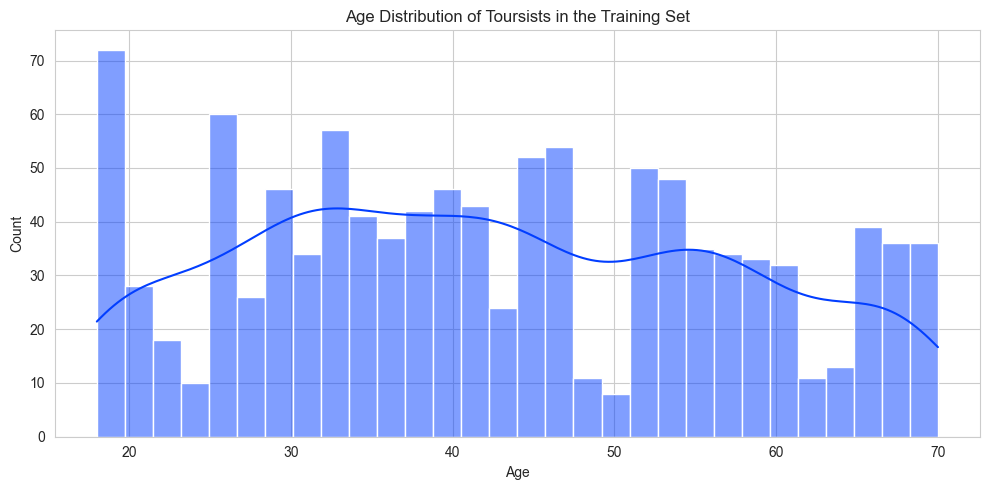

In [243]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.histplot(
    data=tourist_df_eda,
    x='Age',
    bins=30,
    kde=True,
    stat='count',
    ax=ax
)
ax.set_title('Age Distribution of Toursists in the Training Set')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Age distribution of tourists is close to uniform distribution, with slight less data samples of elder people above 60 years old. A relatively high number of tourists with age is concentrated in the middle-age group, between 30 and 50 years old. On the other hand, a high spike is noticed of under 20 years old tourists, as well as moderate number of tourists in the young age group, under 30 years old.

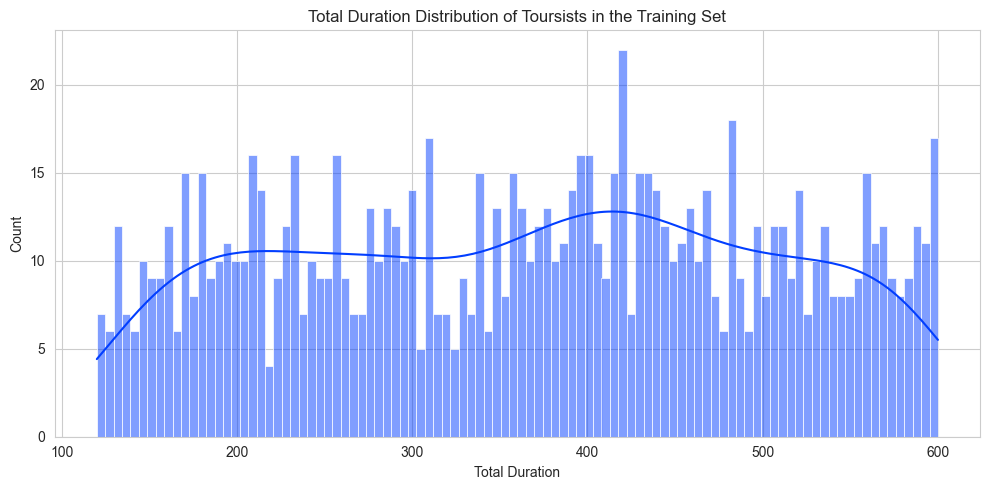

In [244]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.histplot(
    data=tourist_df_eda,
    x='Total_Duration',
    bins=100,
    kde=True,
    stat='count',
    ax=ax
)
ax.set_title('Total Duration Distribution of Toursists in the Training Set')
ax.set_xlabel('Total Duration')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Total Duration of the Trips are similarly uniformly distributed, with tourist trips between 100 and 600 minutes.

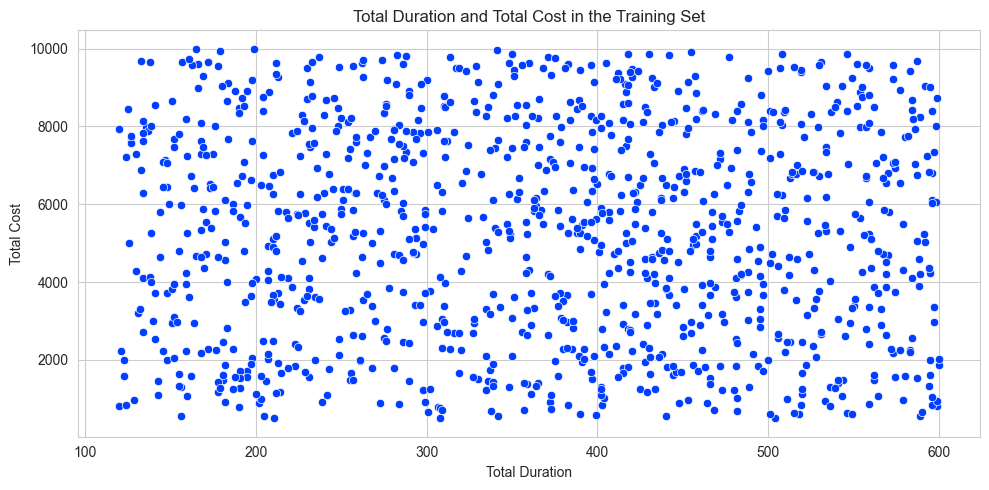

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.scatterplot(
    data=tourist_df_eda,
    x='Total_Duration',
    y='Total_Cost',
    ax=ax
)
ax.set_title('Total Duration and Total Cost in the Training Set')
ax.set_xlabel('Total Duration')
ax.set_ylabel('Total Cost')

plt.tight_layout()
plt.show()

No useful information can be extracted from the scatter plot of Total Cost and Total Duration Features.

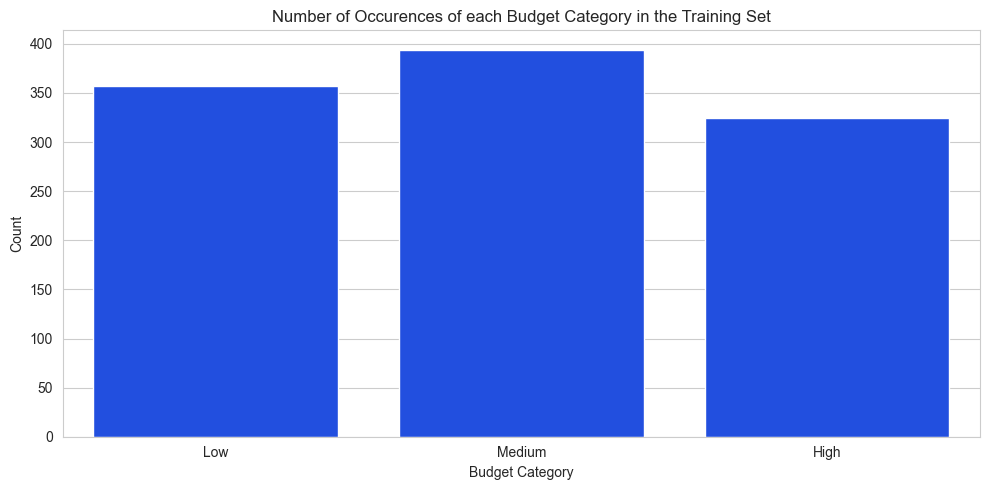

In [246]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Budget_Category',
    ax=ax
)
ax.set_title('Number of Occurences of each Budget Category in the Training Set')
ax.set_xlabel('Budget Category')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Relatively similar number of occurences of tourists with different types of Budget Category, making this feature a balanced one. However, most of tourists are from Medium Budget Category, while the lowest number is of tourists from High Budget Category.

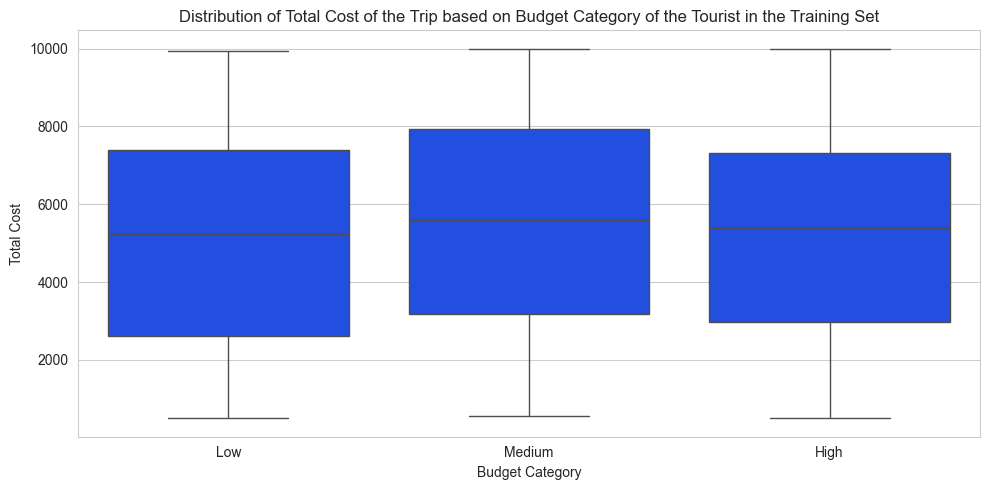

In [247]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    data=tourist_df_eda,
    x='Budget_Category',
    y='Total_Cost',
    ax=ax
)
ax.set_title('Distribution of Total Cost of the Trip based on Budget Category of the Tourist in the Training Set')
ax.set_xlabel('Budget Category')
ax.set_ylabel('Total Cost')

plt.tight_layout()
plt.show()

According to the distributions of the Total Cost per each Budget Category, there is a difference between the average values and overall distribution of the Total Cost compared to other Budget Categories. Tourists of Medium Budget Category spent higher total cost per their trip, on average a Total Cost between $\approx 3800$ and $\approx 8000$ Monetary Units (M.U.), while tourists of Lower and Higher Budget Category, spent on average, similar costs per their trips $\approx 5000$ M.U., and, for the Low Budget Category of Tourists, the average concentration of data samples was between $\approx 2500$ M.U. and $\approx 7300$ M.U., representing wider range of value than in the case of tourists with High Budget Category, that presented most of their trips with total cost between $\approx 3000$ and $\approx 7200$ M.U.

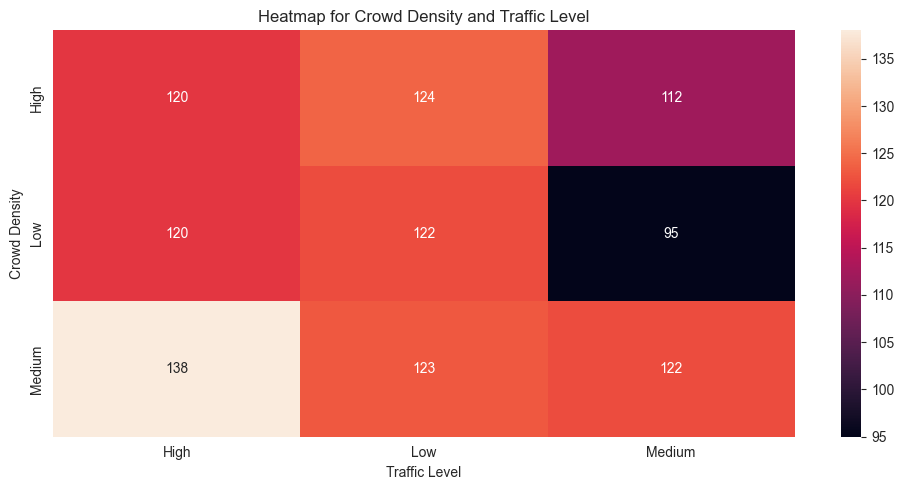

In [248]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Crowd_Density"], tourist_df_eda["Traffic_Level"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Crowd Density and Traffic Level")
plt.ylabel("Crowd Density")
plt.xlabel("Traffic Level")
plt.tight_layout()
plt.show()

As it may be seen, no significant correlation between Traffic Level and Crowd Density in the context of the problem. The only difference is in the number of samples when Traffic Level is Medium, that resulted in lower number of trips where tourists encountered Low Crowd Density. Therefore, no conclusive results were obtained.

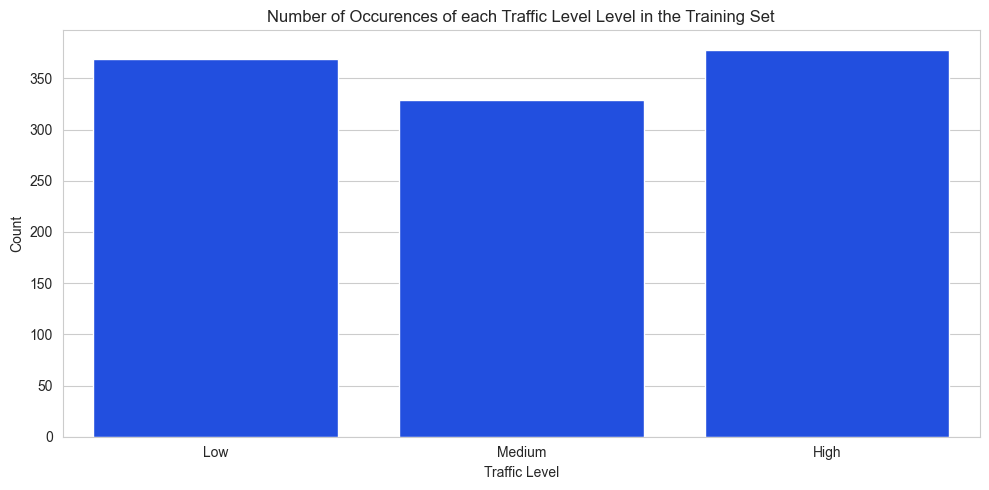

In [249]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Traffic_Level',
    ax=ax
)
ax.set_title('Number of Occurences of each Traffic Level Level in the Training Set')
ax.set_xlabel('Traffic Level')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

More tourists encountered either High or Low levels of Traffic - above 350 records of High Level of Traffic, similar for Low Level of Traffic. Least amount of occurences in the dataset are of trips with Medium Traffic Level.

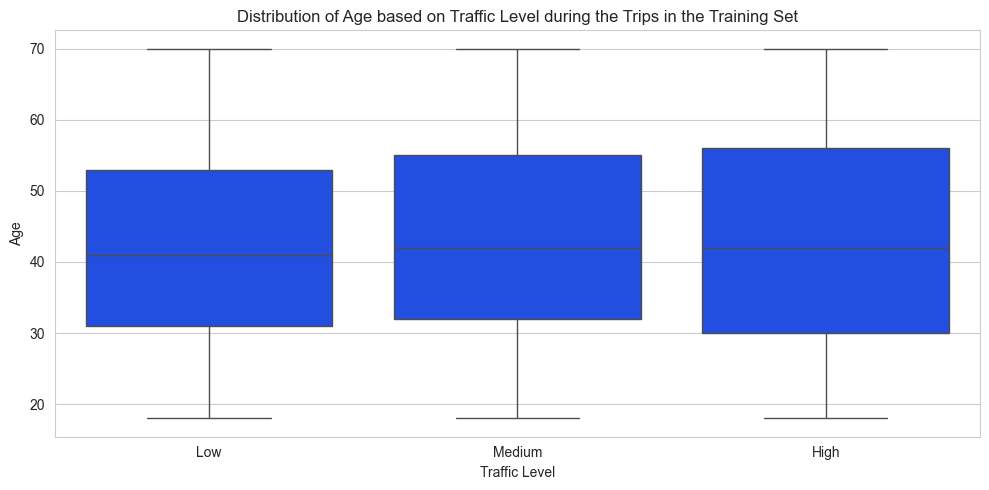

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    data=tourist_df_eda,
    x='Traffic_Level',
    y='Age',
    ax=ax
)
ax.set_title('Distribution of Age based on Traffic Level during the Trips in the Training Set')
ax.set_xlabel('Traffic Level')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

As it may be seen, Median Age of the tourists that encountered various types of Traffic Level is similar, $\approx 40-42$ years old. The spread of the boxplot in all three cases of Traffic Level is similar - $\approx 25$ years old, with higher range of values in the Inter-Quantile Range for trips with High Traffic Level, where the range of possible values is $\approx 26$ years old. However, the differences are minimal, therefore no significant information about Age corresponding to the Traffic Level is derived

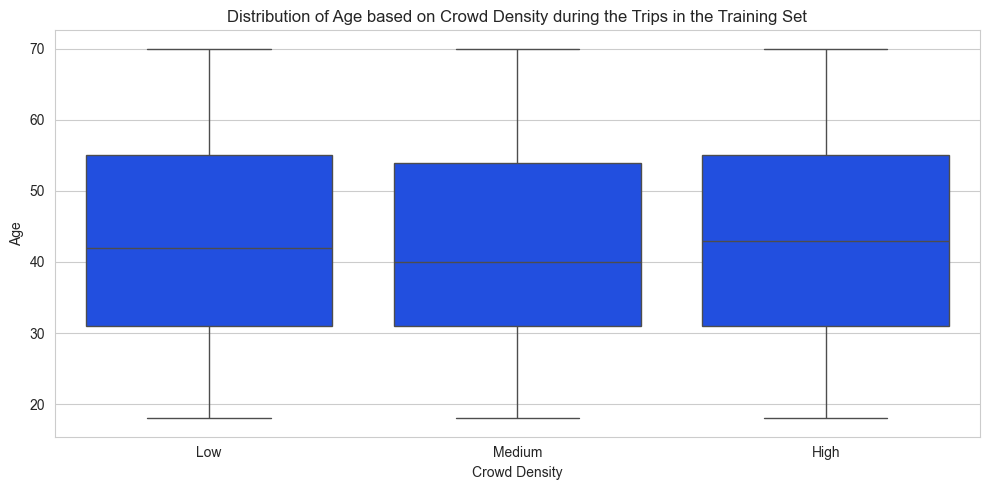

In [251]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    data=tourist_df_eda,
    x='Crowd_Density',
    y='Age',
    ax=ax
)
ax.set_title('Distribution of Age based on Crowd Density during the Trips in the Training Set')
ax.set_xlabel('Crowd Density')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

In this case, Median Age is slightly different for each of the possible categories of Crowd Density. In this case, Median Age for Low Crowd Density encounter during the tourists trip is $\approx 42$, while for Medium Crowd Density is $\approx 40$, and for High Crowd Density encounter - $\approx 43$, which, again, does not indicate strong dependence between Age groups and Crowd Density. The spread in all three boxplots is similar, with main density of samples between $\approx 31 - 54$ years old.

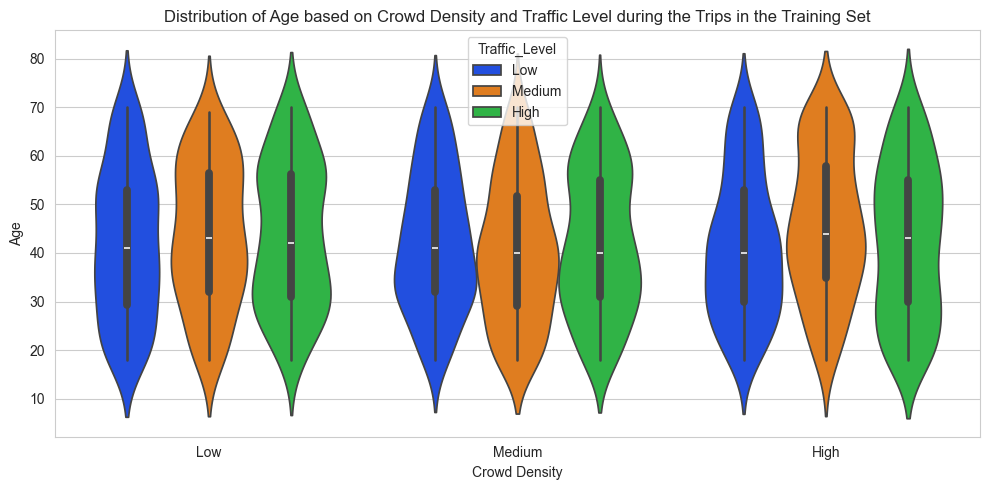

In [252]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.violinplot(
    data=tourist_df_eda,
    x='Crowd_Density',
    y='Age',
    hue='Traffic_Level',
    ax=ax
)
ax.set_title('Distribution of Age based on Crowd Density and Traffic Level during the Trips in the Training Set')
ax.set_xlabel('Crowd Density')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

As it may be seen, the conclusions from previous two plots can be seen in this one as well. One difference is that when Crowd Density was Medium, the main age group shifted to people between $30 - 40$ years old, while when Low Crowd Density and Low Traffic Level was encountered, there was a quite uniform distribution of possible age groups, while when Traffic Level was High, the main age groups concentrated in older population and younger population with a decrease in middle-aged category of tourists. Besides that, when Crowd Density was higher, Lower Traffic Level concentration of the age is closer to $30 - 40$ years old, and in higher levels of Traffic, the age group concentration was higher, above 40 years old.

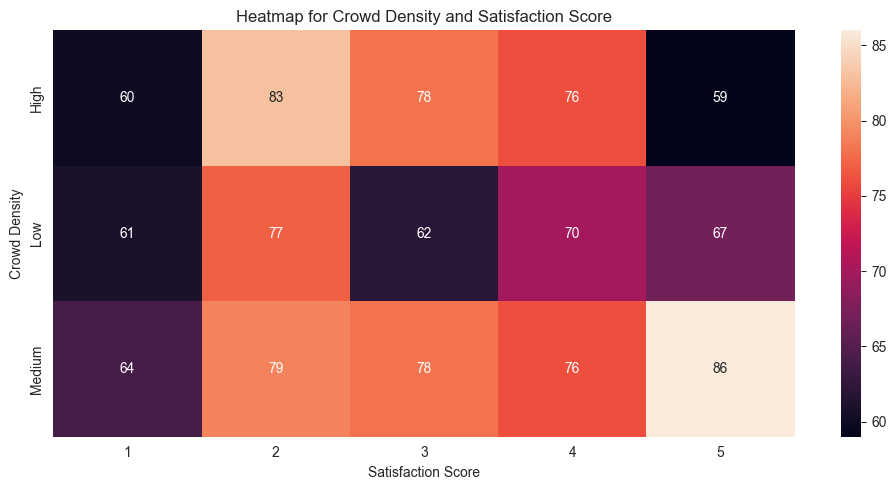

In [253]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Crowd_Density"], tourist_df_eda["Satisfaction_Score"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Crowd Density and Satisfaction Score")
plt.ylabel("Crowd Density")
plt.xlabel("Satisfaction Score")
plt.tight_layout()
plt.show()

As it may be seen, highest number of satisfaction score of $5$ and $4$ were given when Crowd Density was of Medium Level. Besides that, trips with Low Crowd Density had the lowest number of High Satisfaction Scores. At the same time, trips with High Crowd Density resulted in the lowest rate of highest Satisfaction Score, but the highest rate of Satisfaction Score of $2$. 

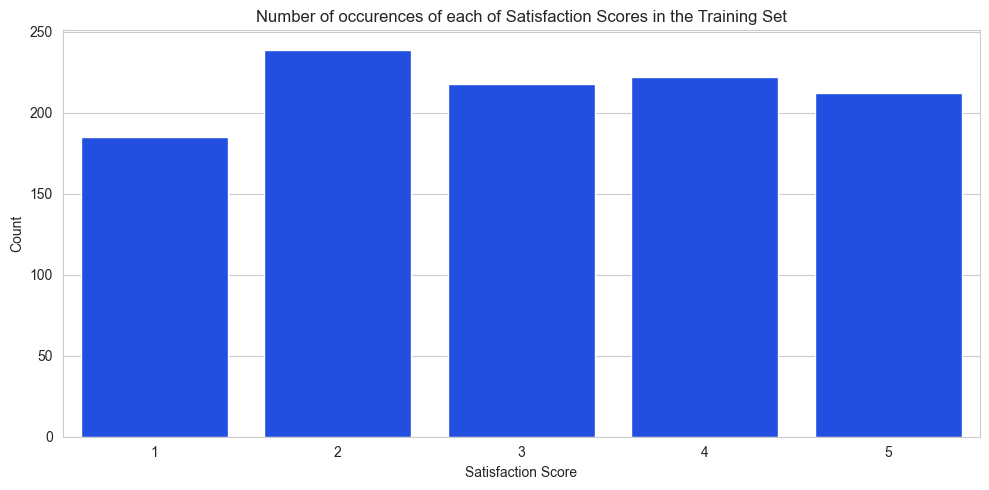

In [254]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Satisfaction_Score',
    ax=ax
)
ax.set_title('Number of occurences of each of Satisfaction Scores in the Training Set')
ax.set_xlabel('Satisfaction Score')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

A Satisfaction Score of $1$ was recorded in the least amount of samples - $\approx 180$, while highest records were of Satisfaction Score of $2$ - $\approx 240$, and a steady number of data points was shared between Satisfaction Scores $3, 4, 5$ - $\approx 210$. 

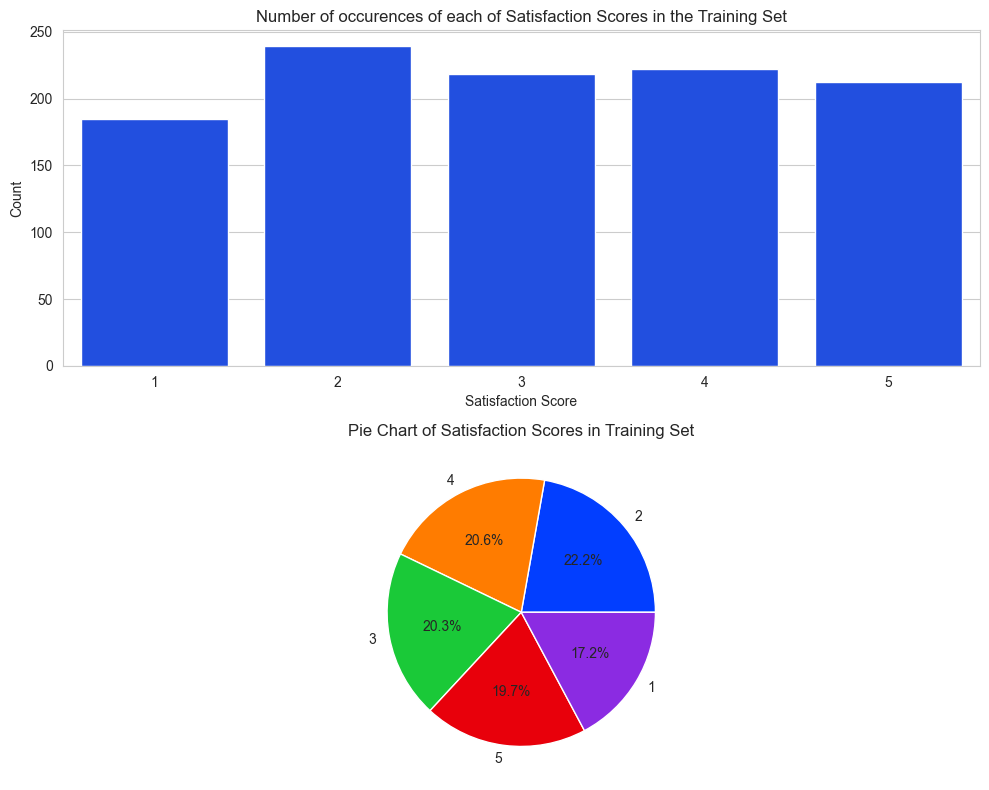

In [255]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

sns.countplot(
    data=tourist_df_eda,
    x='Satisfaction_Score',
    ax=axes[0]
)
axes[0].set_title('Number of occurences of each of Satisfaction Scores in the Training Set')
axes[0].set_xlabel('Satisfaction Score')
axes[0].set_ylabel('Count')

axes[1].pie(
    tourist_df_eda['Satisfaction_Score'].value_counts(),
    autopct='%1.1f%%',
    labels=tourist_df_eda['Satisfaction_Score'].value_counts().index
)
axes[1].set_title('Pie Chart of Satisfaction Scores in Training Set')

plt.tight_layout()
plt.show()

Satisfaction Score feature is relatively balanced, with similar proportion of all possible scores, with slightly less records with a score of $1$.

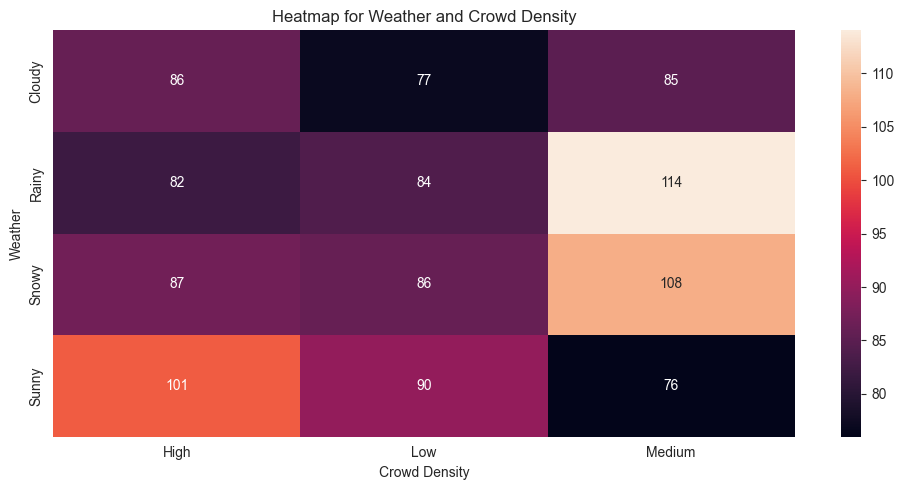

In [256]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Weather"], tourist_df_eda["Crowd_Density"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Weather and Crowd Density")
plt.ylabel("Weather")
plt.xlabel("Crowd Density")
plt.tight_layout()
plt.show()

Highest number of trips with High Crowd Density was encountered on Sunny Weather, while the lowest number of records were with Medium Crowd Density on Sunny Weather and Low Crowd Density on Cloudy Weather. Besides that, Medium Crowd Density was encountered more on Rainy and Snowy Weather, while in other cases, no significant difference was observed based on Weather and Crowd Density relationship, most of the combinations were relatively the same, between $82 - 90$ trips. Therefore, the main relation was oberved when Sunny Weather was present during the trip, that resulted in low number of Medium Crowd Density trips and very High Crowd Density Levels. High Crowd Density were encountered less on Rainy Weather.

In [257]:
min_age = tourist_df_eda['Age'].min()
max_age = tourist_df_eda['Age'].max()

age_bins = [min_age, 30, 40, 50, 60, max_age]
age_labels = [f'{min_age}-30', '31-40', '41-50', '51-60', f'61-{max_age}']

age_binned = pd.cut(tourist_df_eda['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

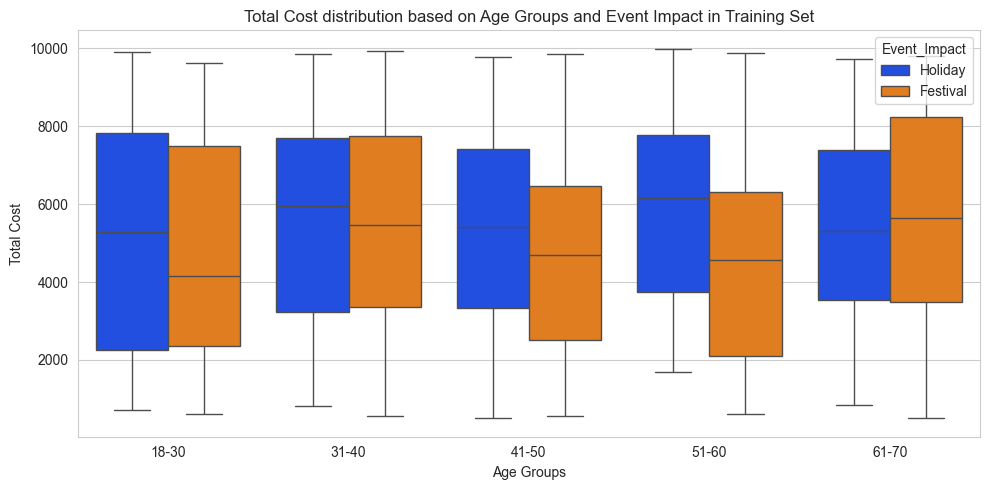

In [258]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    x=age_binned,
    y=tourist_df_eda['Total_Cost'],
    hue=tourist_df_eda['Event_Impact'],
    ax=ax
)

ax.set_title('Total Cost distribution based on Age Groups and Event Impact in Training Set')
ax.set_xlabel('Age Groups')
ax.set_ylabel('Total Cost')

plt.tight_layout()
plt.show()

As it may be seen, young people spent on average more money on Holiday Trips, median value $\approx 5300$ M.U., while on Festivals they spent a median cost of $\approx 4100$ M.U. Besides that, people above 60 spent more on Festivals - $\approx 5800$ M.U., while on Holidays - $\approx 5600$. More over, middle-aged people spent on Holidays much more than on Festivals - $\approx 5700 - 6000$ M.U., while of Festivals - between $\approx 4700 - 5700$ M.U., thus, younger and middle-aged tourist spent less money on festival trips, while older population focused more finances on Festivals.

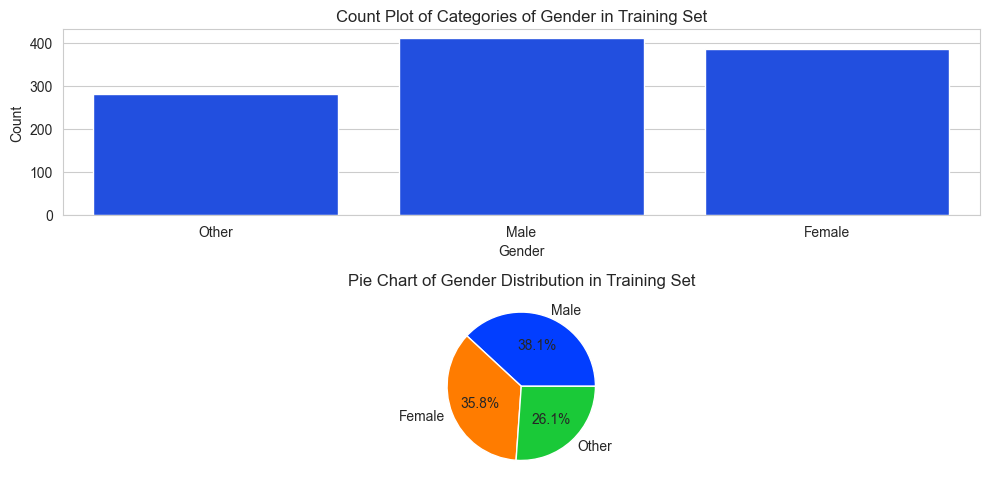

In [259]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Gender',
    ax=axes[0]
)

axes[0].set_title('Count Plot of Categories of Gender in Training Set')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

axes[1].pie(
    tourist_df_eda['Gender'].value_counts(),
    autopct='%1.1f%%',
    labels=tourist_df_eda['Gender'].value_counts().index
)
axes[1].set_title('Pie Chart of Gender Distribution in Training Set')

plt.tight_layout()
plt.show()


Lowest number of records in the dataset are of Tourists that specified their Gender as Other, while the distribution between Females and Males is balanced, the number of records of the third category of this feature is less than other two by $\approx 100$ records. As detailed in the pie chart, it has lowest proportion.

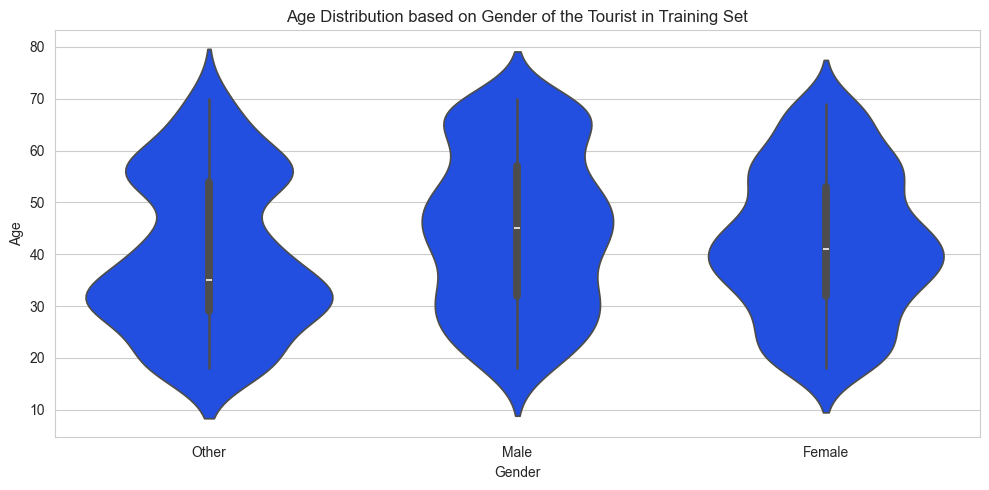

In [260]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.violinplot(
    data=tourist_df_eda,
    x='Gender',
    y='Age',
    ax=ax
)

ax.set_title('Age Distribution based on Gender of the Tourist in Training Set')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

As it may be seen, tourists that specified their gender as Other, have a higher concentration of age values between $\approx 29 - 54$, with median value of $\approx 35$ and main concentration of such records around $31$ years old, much younger than other two categories of Gender. Females have lower median age - $\approx 41$ and high number of records of $\approx 40$ years olds and Males - $\approx 45$ with relative uniform distribution of the age across the age groups. As a result, tourists with different gender than Female and Male presented younger to lower middle age groups, while Females and Males Tourists converged to upper middle age.

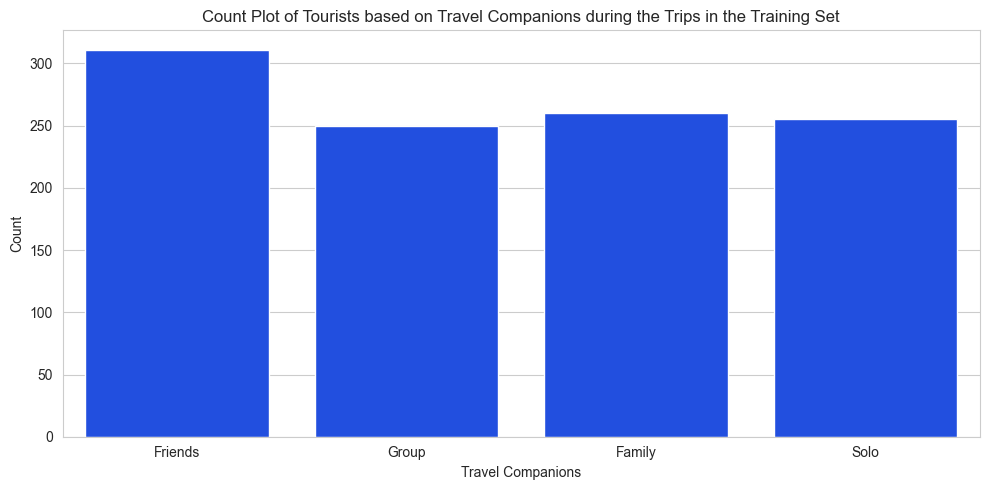

In [261]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Travel_Companions',
    ax=ax
)
ax.set_title('Count Plot of Tourists based on Travel Companions during the Trips in the Training Set')
ax.set_xlabel('Travel Companions')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Most of the tourists travelled with their Friends - $\approx 310$ recorded trips, while Group, Family and Solo trips were of pretty much the same number of occurences, $\approx 250$ trips.

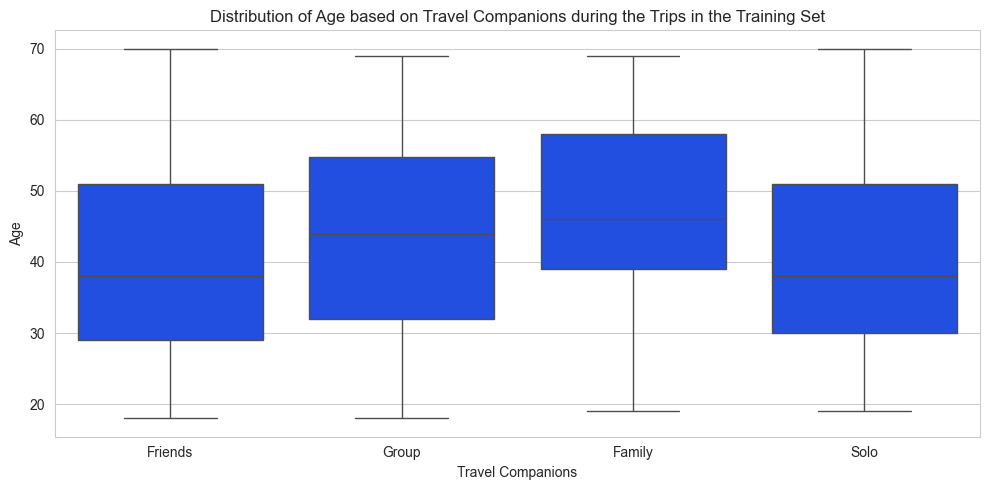

In [262]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    data=tourist_df_eda,
    x='Travel_Companions',
    y='Age',
    ax=ax
)
ax.set_title('Distribution of Age based on Travel Companions during the Trips in the Training Set')
ax.set_xlabel('Travel Companions')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

As it may be noticed, tourists that travelled Solo or with Friends were the youngest people, under 40 years old, while Group Trips had a median age of $\approx 44$ years old, and the oldest age group travelled with their Families - $\approx 46$ years old.

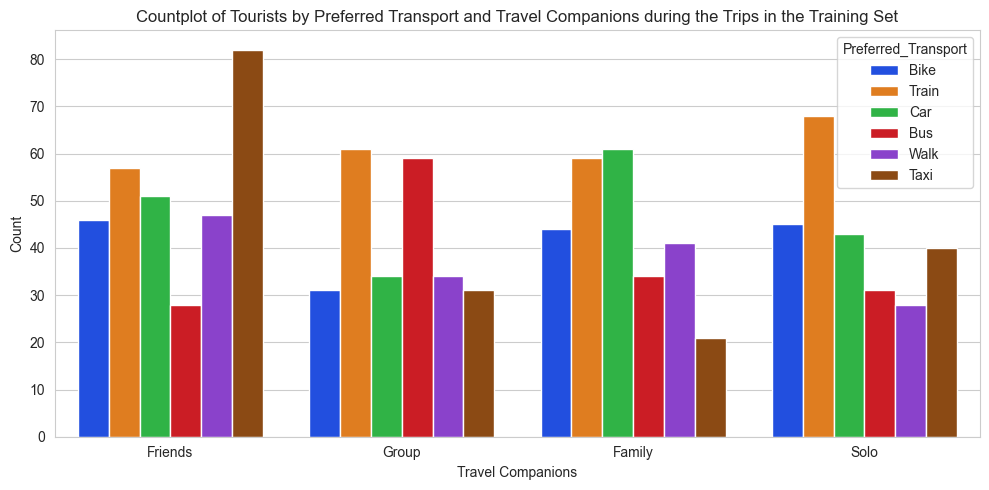

In [263]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Travel_Companions',
    hue='Preferred_Transport',
    ax=ax
)
ax.set_title('Countplot of Tourists by Preferred Transport and Travel Companions during the Trips in the Training Set')
ax.set_xlabel('Travel Companions')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

As it may be noticed, Tourists that travelled with their Friends preferred Taxi Trips, this being the highest number across all types of Travel Companions and Preferred Transports, as well as Train and Car trips also were on a relatively high proportion of this category, whereas trips done by bus were less likely to occur in this category. Tourists that travelled in Group, preferred transport was either Bus and Train and least preferred was bikes and taxies, which is logic, since Group Trips require transport with high number of seats. On the other hand, Family Trips registered that highest number of records were done by car and train, as well as bikes, while lowest rate of preference was registered by taxi and bus. Last group, Solo tourists, preferred more than any other category, Trains and Bikes, as well as Cars, and least amount of records were registered by walk and bus.

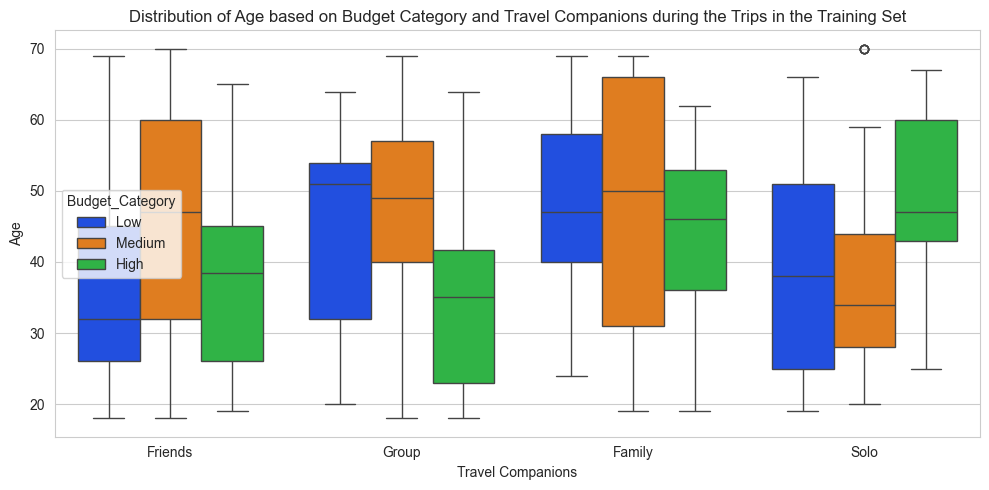

In [264]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    data=tourist_df_eda,
    x='Travel_Companions',
    y='Age',
    hue='Budget_Category',
    ax=ax
)
ax.set_title('Distribution of Age based on Budget Category and Travel Companions during the Trips in the Training Set')
ax.set_xlabel('Travel Companions')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

In the category of tourists that travelled with Friends, upper middle-aged people presented a Medium Budget Category, while lower-middle aged people presented a Low Budget and middle-aged people had High Budget during their trip, but with samples of younger groups as well. In contrast, people that travelled in Group, presented High Budget in younger age groups, but Low and Medium Budget in upper middle-aged class of tourists. Tourists that travelled with their families manifested overall higher age group as well as a significant shift in Budget Distribution upper in the age class. However, this category of tourists had a high variance in Medium Budget class. Tourists that travelled solo, had Low and Medium Budget in younger age groups, while High Budget for the trip presented elder people.

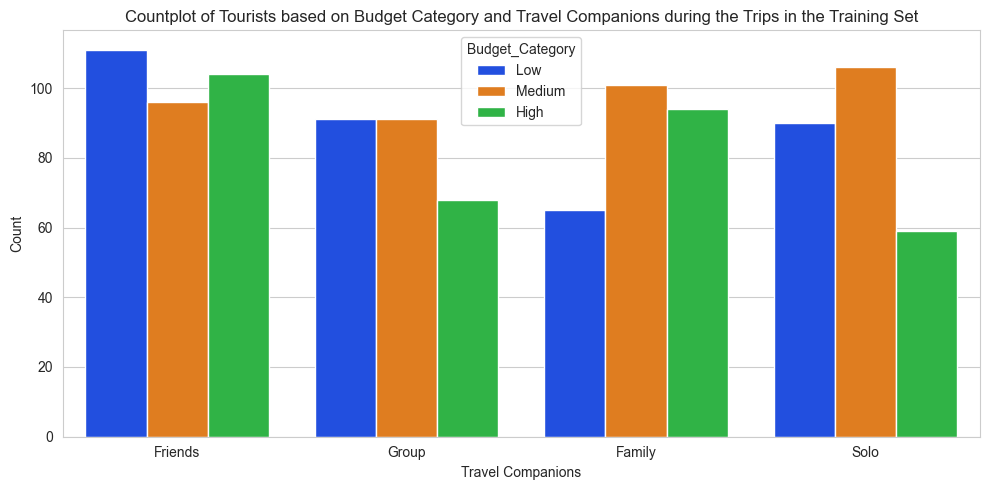

In [265]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Travel_Companions',
    hue='Budget_Category',
    ax=ax
)
ax.set_title('Countplot of Tourists based on Budget Category and Travel Companions during the Trips in the Training Set')
ax.set_xlabel('Travel Companions')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Tourists that travelled with Friends had highest number of records of Low Budget, and least amount of records of Medium Budget, while people that travelled in group had similar number of records of Low and Medium Budget Category and much less records with High Budget. Families of tourists had the least number of records with Low Budget, and higher Medium and High Budget than in case of Group Traveling. Tourists that travelled alone had the highest number of occurences of Medium Budget and least amount of records of High Budget.

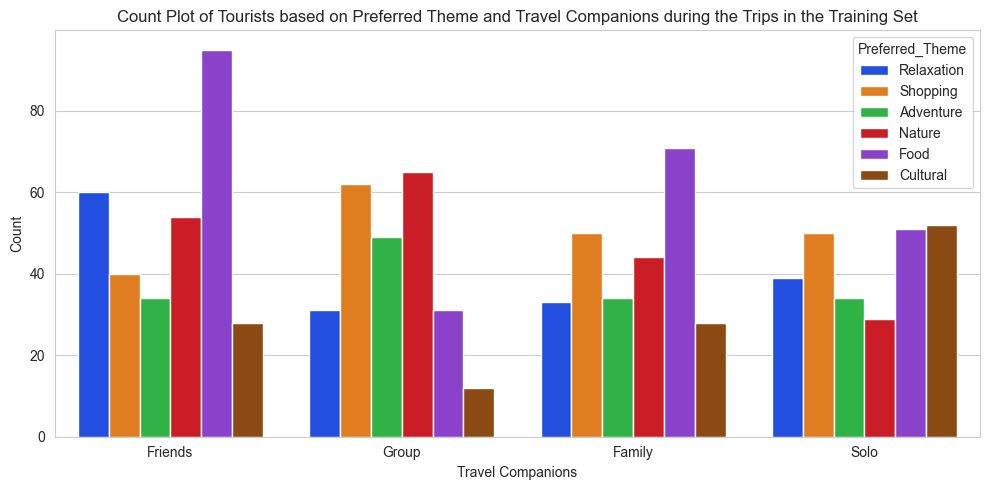

In [266]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Travel_Companions',
    hue='Preferred_Theme',
    ax=ax
)
ax.set_title('Count Plot of Tourists based on Preferred Theme and Travel Companions during the Trips in the Training Set')
ax.set_xlabel('Travel Companions')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

As it may be noticed, Tourists that travelled with Friends manifested more interest in Food Events and Relaxation, as well as Nature-themed Trips, while lowest interest was recorded in Cultural and Adventure Themes. Tourists that travelled in Groups, had higher number of Nature and Shopping-themed trips, with lowest number of Cultural, Food and Relaxation trips. On the other hand, tourists that travelled with families had highest interest in Food and Shopping, as well sa Nature-themed trips, while relative uniform interest in Aventure, Cultural and Relaxation trips. Tourists that travelled Solo, had uniform interest in Food, Cultural and Shopping trips, and lowest interest in Nature and Adventure-themed route trips.

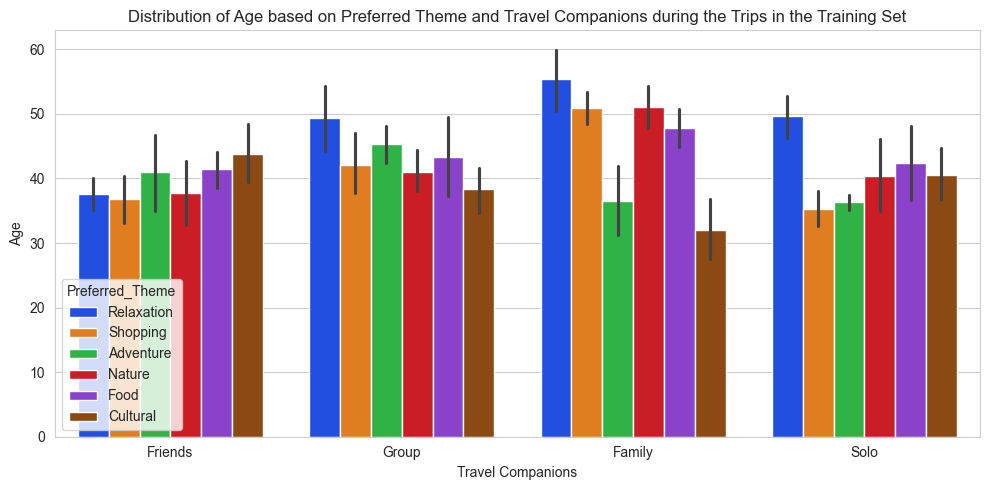

In [267]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.barplot(
    data=tourist_df_eda,
    x='Travel_Companions',
    y='Age',
    hue='Preferred_Theme',
    ax=ax
)
ax.set_title('Distribution of Age based on Preferred Theme and Travel Companions during the Trips in the Training Set')
ax.set_xlabel('Travel Companions')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

Tourists that travelled with Friends highed average age was recorded in Cultural, Food and Adventure trips - $\approx 40-43$ years old, while younger people had interest in Shopping, Relaxation and Nature trips - $\approx 35-37$ years old. At the same time, tourists that travelled in groups, had higher average age in trips with Relaxation and Adventure, while in Cultural and Nature-themed trips were interested younger age groups. Besides that, tourists that travelled with their family, older age groups, above $\approx 48$ were interested in Relaxation, Shopping, Nature and Food Trips, while younger tourists were involved in Adventure and Cultural trips. Older Tourists that travelled on their own, were interested mainly in Relaxation trips, while middle-aged groups were involved in Adventure and Shopping, while upper-middle aged groups were involved in more Nature, Food and Cultural Trips.

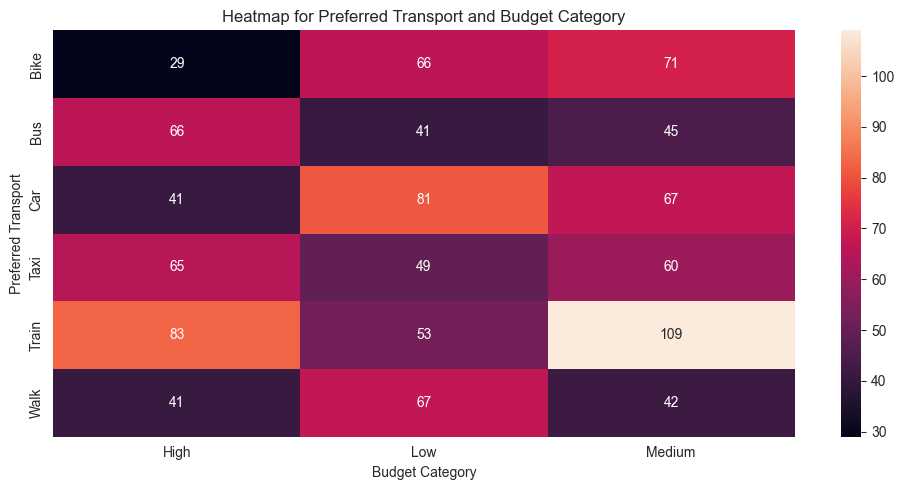

In [268]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Preferred_Transport"], tourist_df_eda["Budget_Category"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Preferred Transport and Budget Category")
plt.ylabel("Preferred Transport")
plt.xlabel("Budget Category")
plt.tight_layout()
plt.show()

As it may be seen, tourists with High Budget Category avoided Bike trips, as well as Walk and Car trips. They preferred to use Trains, Taxis and Buses. Medium Budget Category tourists relied a lot more on Train as a preferred Transport, while avoiding Walk and Bus Trips and preferred moderately Cars and Bike Trips. Tourists in Medium Budget Category used extensively Cars as transport during Trips, as well as Bikes and Walks.

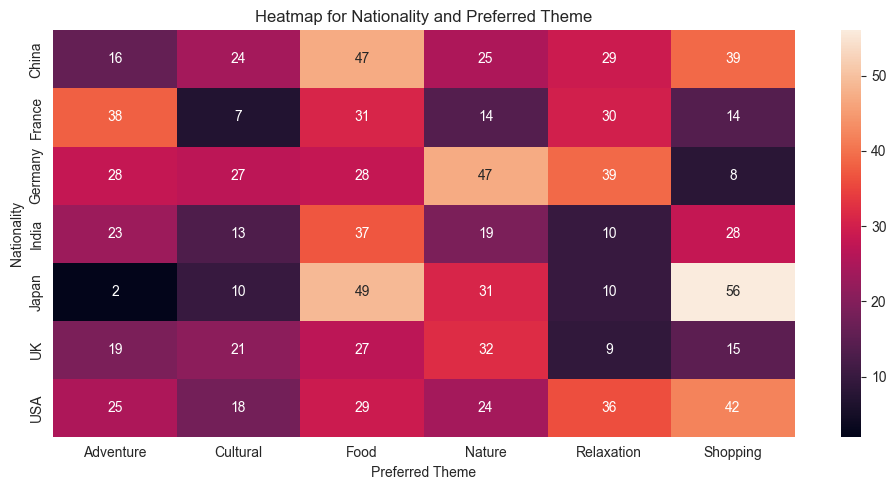

In [269]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Nationality"], tourist_df_eda["Preferred_Theme"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Nationality and Preferred Theme")
plt.ylabel("Nationality")
plt.xlabel("Preferred Theme")
plt.tight_layout()
plt.show()

Tourists that visited from asian countries - China, India and Japan, were more interested in Food-Themed Trips and Shopping Trips, while less interested in Adventure and Relaxation trips. In contrast, tourists from France were more involved in Adventure, Food and Relaxation Trips and less involved in Cultural Trips. At the same time, German tourists were interested in more Nature and Relaxation-themed trips, while UK tourists were involved in Nature and moderately interested in Food-themed Trips, and less involved in Relaxation and Shopping, the same as German and France tourists. USA tourists were involved in Shopping and Relaxation a lot more than in Cultural events.

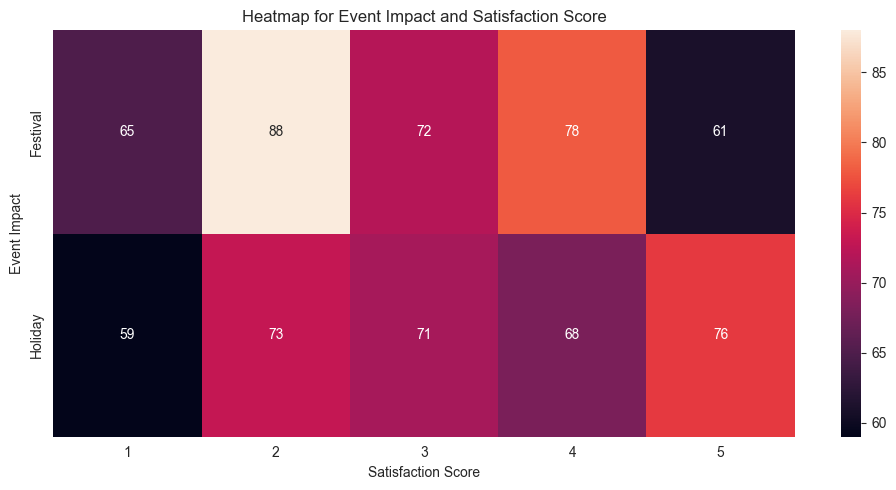

In [270]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Event_Impact"], tourist_df_eda["Satisfaction_Score"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Event Impact and Satisfaction Score")
plt.ylabel("Event Impact")
plt.xlabel("Satisfaction Score")
plt.tight_layout()
plt.show()

Higher Satisfaction score was given to events during the trip that were related to Holidays - $75$ occurences of Satisfaction Score of $5$ and slightly less Satisfaction Scores of $4$, while for Festivals the least amount of records had a $5$ for Satisfaction Score, while highest number of records were with $2$ as a Satisfaction Score and relatively high number of mixed Scores of $3$ and $4$. This shows a slightly higher overall Satisfaction Score given to Holiday Events during their Trips, while Festival Trips resulted in lower Satisfaction Score.

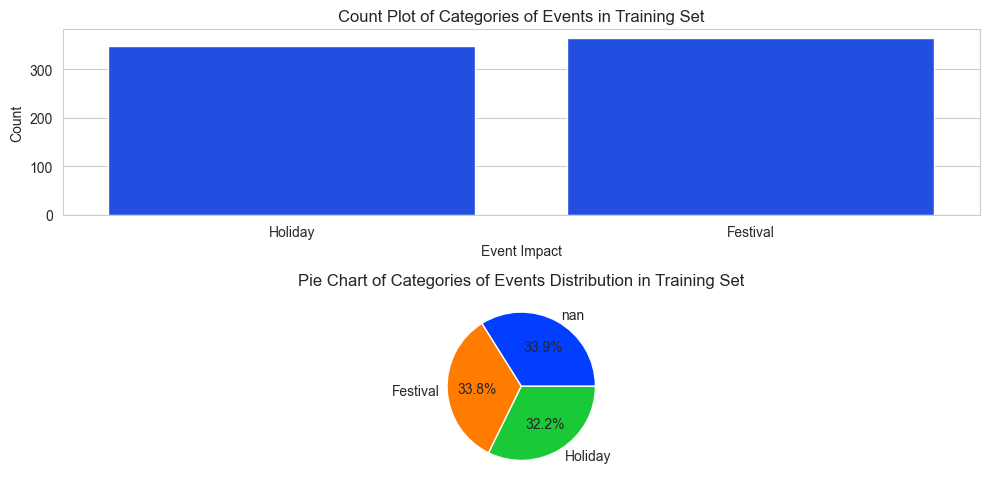

In [271]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Event_Impact',
    ax=axes[0]
)

axes[0].set_title('Count Plot of Categories of Events in Training Set')
axes[0].set_xlabel('Event Impact')
axes[0].set_ylabel('Count')

axes[1].pie(
    tourist_df_eda['Event_Impact'].value_counts(dropna=False),
    autopct='%1.1f%%',
    labels=tourist_df_eda['Event_Impact'].value_counts(dropna=False).index
)
axes[1].set_title('Pie Chart of Categories of Events Distribution in Training Set')

plt.tight_layout()
plt.show()


As it may be seen, similar distribution of categories of Events per tourists. A significant portion of the feature data is missing $33.9\%$. At the same time, this should be treated accordingly. In order to do that, first several observations should be made on the nature of those missing values, since there are several types of missing values:
1. Missing Completely at Random (MCAR) - Data is considered MCAR if the missing values have no relationship with any other variables in the dataset. The missing values occur purely by chance. The missing values on a given variable $(Y)$ are not associated with other variables in a given data set or with the variable $(Y)$ itself. In other words, there is no particular reason for the missing values.
2. Missing at Random (MAR) - In MAR, the missing values depend on observed variables but not on the missing values themselves. MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.
3. Missing Not at Random (MNAR) - Data is MNAR if the missing values are dependent on unobserved information, making it the hardest type to handle. Missingness depends on unobserved data or the value of the missing data itself.

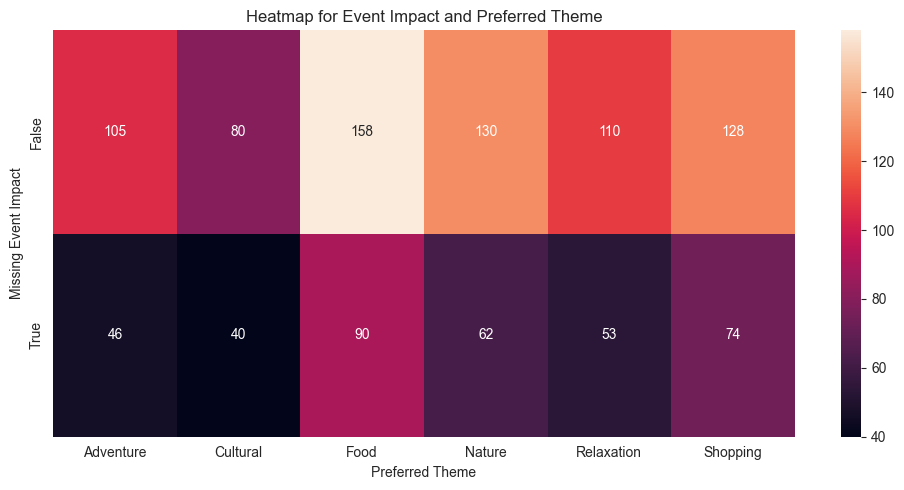

In [272]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Event_Impact"].isnull(), tourist_df_eda["Preferred_Theme"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Event Impact and Preferred Theme")
plt.ylabel("Missing Event Impact")
plt.xlabel("Preferred Theme")
plt.tight_layout()
plt.show()

No significant relation between missing values of Event Impact and Preferred Theme was observed. However, relativelly low proportion of Relaxation Trips with missing value of Event Impact. In other categories, the proportion is similar to the ones with present value of Event Impact.

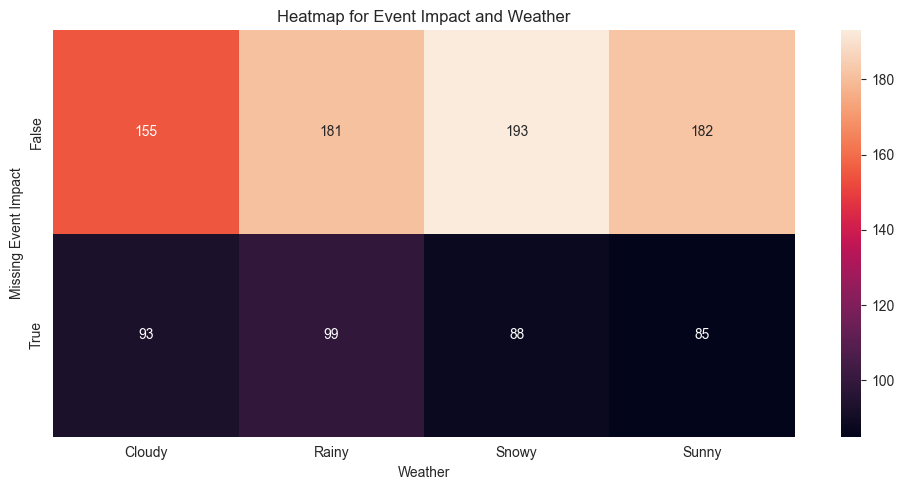

In [273]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Event_Impact"].isnull(), tourist_df_eda["Weather"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Event Impact and Weather")
plt.ylabel("Missing Event Impact")
plt.xlabel("Weather")
plt.tight_layout()
plt.show()

Relatively uniform partition of occurences when Event Impact is missing, similar to cases when this value is present.

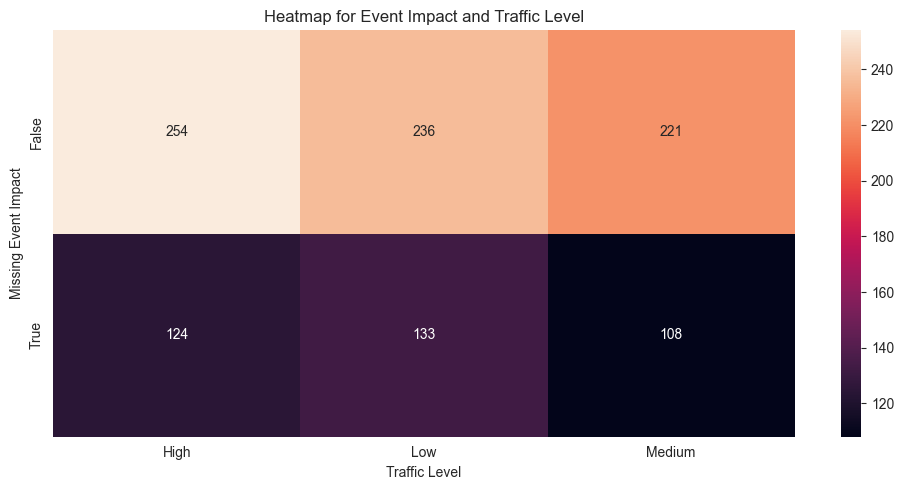

In [274]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Event_Impact"].isnull(), tourist_df_eda["Traffic_Level"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Event Impact and Traffic Level")
plt.ylabel("Missing Event Impact")
plt.xlabel("Traffic Level")
plt.tight_layout()
plt.show()

Again, number of occurences when this field is missing has the same distribution as if the value was present.

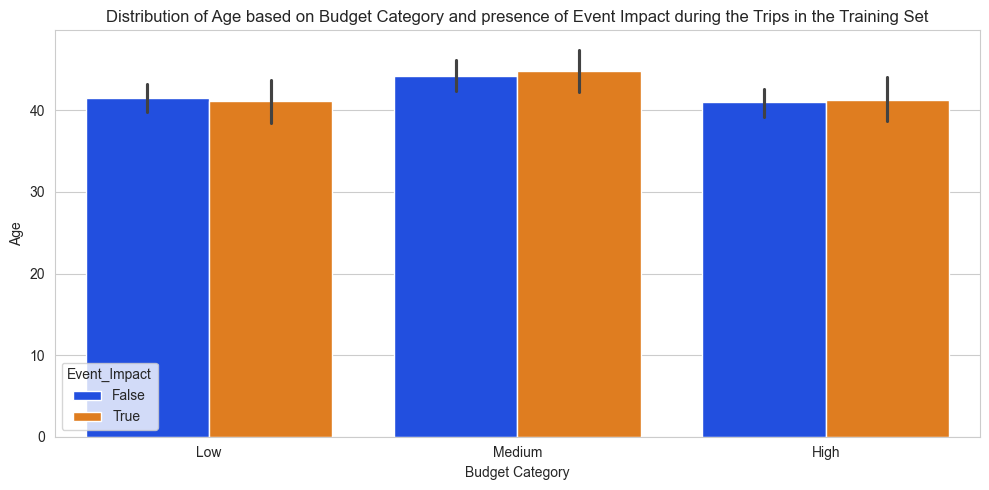

In [275]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.barplot(
    x=tourist_df_eda['Budget_Category'],
    y=tourist_df_eda['Age'],
    hue=tourist_df_eda["Event_Impact"].isnull(),
    ax=ax
)
ax.set_title('Distribution of Age based on Budget Category and presence of Event Impact during the Trips in the Training Set')
ax.set_xlabel('Budget Category')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

Similar average age in both missing and present cases of Event Impact feature based on Budget Category.

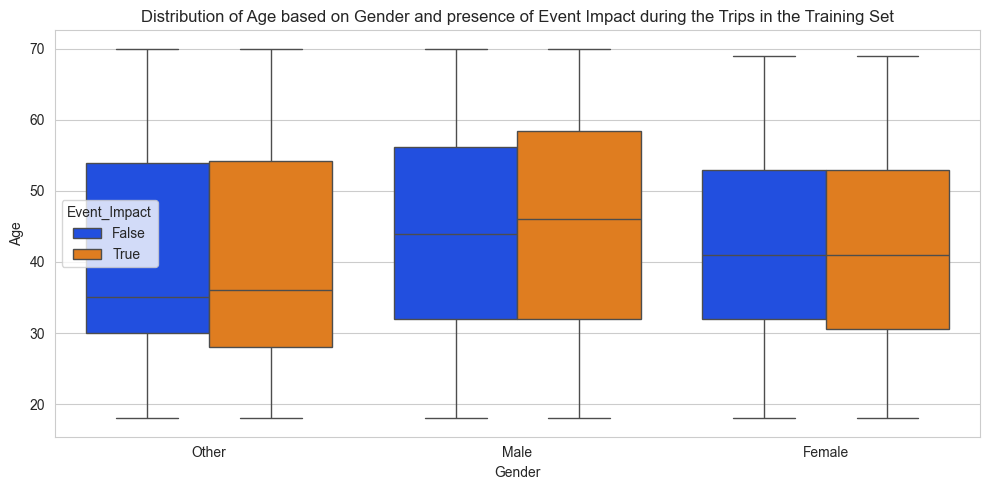

In [276]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    x=tourist_df_eda['Gender'],
    y=tourist_df_eda['Age'],
    hue=tourist_df_eda["Event_Impact"].isnull(),
    ax=ax
)
ax.set_title('Distribution of Age based on Gender and presence of Event Impact during the Trips in the Training Set')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

Similar median age per gender in both cases when Event Impact value is missing or present, with similar Inter-Quantile Range, capturing the same concentrated age groups.

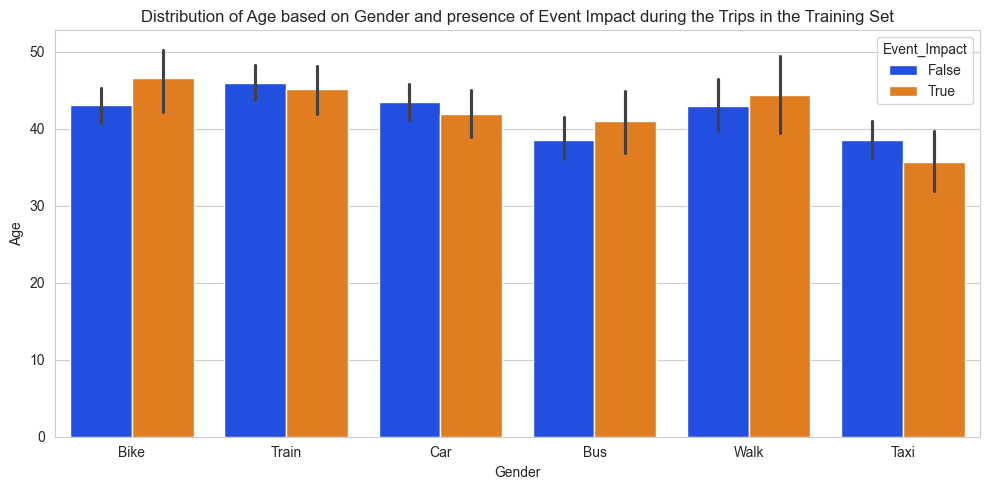

In [277]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.barplot(
    x=tourist_train_df['Preferred_Transport'],
    y=tourist_train_df['Age'],
    hue=tourist_train_df["Event_Impact"].isnull(),
    ax=ax
)
ax.set_title('Distribution of Age based on Gender and presence of Event Impact during the Trips in the Training Set')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

Quite similar average age per each transport category, independent of the presence or missingness of Event Impact feature.

As a result, this feature has missing values either Completely at Random (MCAR) or not at Random (MNAR). In the first case, missing values can be imputed using simple methods of imputation, such mode imputation, where null values are replaced with the most frequent category, or add a new category - $Missing$, that will replace null values, and add a flag feature that will show if the feature value had missing values. This will help as a remedy for MNAR case, by adding unobserved feature about missing data, that could be useful in pattern identification during training process, however it adds complexity, since new feature emerges. Besides that, a solution is to remove rows with missing data, but, since the proportion is very high, it will lead to a dataset with $\frac{1}{3}$ less data than initially present in it.

In [278]:
def compute_num_optimal_nodes(sequence: list[str], optimal_sequence: list[str]) -> int:
    seq_nodes = np.array(sequence.split('->'))
    opt_nodes = np.array(optimal_sequence.split('->'))
    # Element-Wise comparison and summation of the new arrays of True/False values (1/0)
    matches = np.sum(seq_nodes == opt_nodes)
    
    return matches

In [279]:
tourist_df_eda['Num_Stops'] = tourist_df_eda['Sequence'].str.split('->').str.len()
tourist_df_eda['Num_Optimal_Stops'] = tourist_df_eda.apply(lambda row: compute_num_optimal_nodes(row['Sequence'], row['Optimal_Route_Preference']), axis=1)
tourist_df_eda[['Sequence', 'Optimal_Route_Preference', 'Num_Stops', 'Num_Optimal_Stops']]

,Sequence,Optimal_Route_Preference,Num_Stops,Num_Optimal_Stops
Route_ID,,,,
395,38->43->21->41->34->37,21->34->37->38->41->43,6,0
544,49->22->24,22->24->49,3,0
371,1->44->12,1->12->44,3,1
552,1->17->29->35->49->34->6,1->6->17->29->34->35->49,7,1
1331,19->17->18->35->2->27->38,2->17->18->19->27->35->38,7,3
...,...,...,...,...
1096,32->47->9,9->32->47,3,0
1131,25->6->31,6->25->31,3,1
1295,20->40->5->24->47->44,5->20->24->40->44->47,6,0


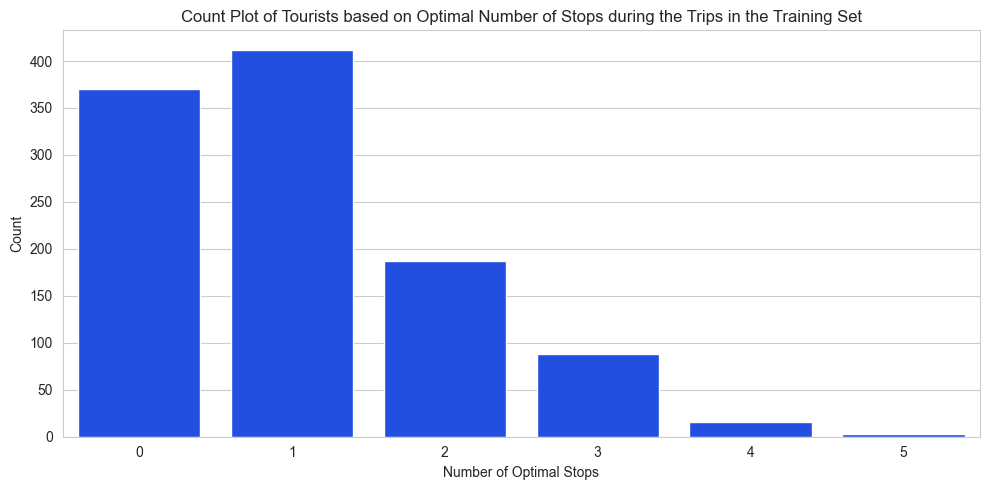

In [280]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.countplot(
    data=tourist_df_eda,
    x='Num_Optimal_Stops',
    ax=ax
)
ax.set_title('Count Plot of Tourists based on Optimal Number of Stops during the Trips in the Training Set')
ax.set_xlabel('Number of Optimal Stops')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Highest value of occurences is held by trips where original sequence and preferred sequence of the route contains $1$ optimal stop, meaning that at a single certain stop from the entire route, the location was preferred by the tourist. Also, high enough are trips with no crossings between optimal and original route stops. Still high enough were trips with $2$ and $3$ stops of this kind, and less occurences of higher values of optimal steps.

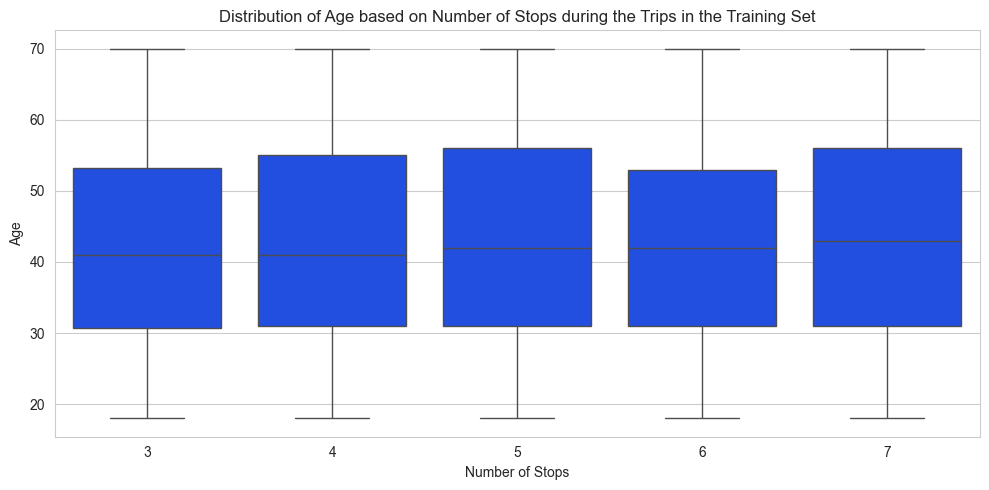

In [281]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(
    x=tourist_df_eda['Num_Stops'],
    y=tourist_df_eda['Age'],
    ax=ax
)
ax.set_title('Distribution of Age based on Number of Stops during the Trips in the Training Set')
ax.set_xlabel('Number of Stops')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()

As it may be noticed, no significant difference in the age groups based on number of stops.

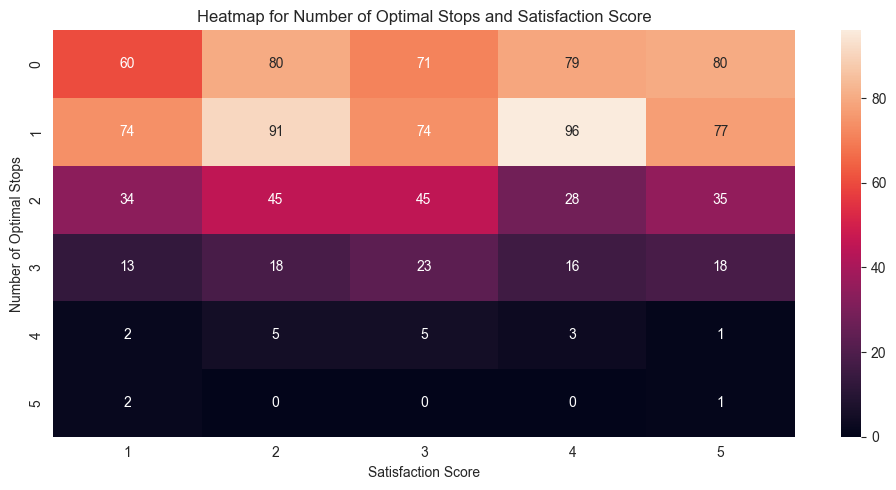

In [282]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Num_Optimal_Stops"], tourist_df_eda["Satisfaction_Score"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Number of Optimal Stops and Satisfaction Score")
plt.ylabel("Number of Optimal Stops")
plt.xlabel("Satisfaction Score")
plt.tight_layout()
plt.show()

As it may be seen, the number of optimal stops did not seem to have an impact on the satisfaction score.

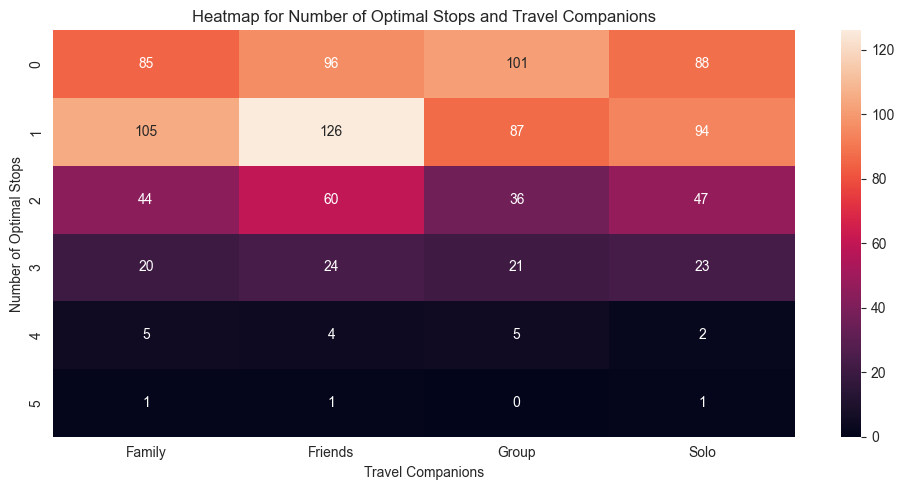

In [283]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

contingency = pd.crosstab(tourist_df_eda["Num_Optimal_Stops"], tourist_df_eda["Travel_Companions"])

sns.heatmap(contingency, annot=True, fmt='d')

plt.title("Heatmap for Number of Optimal Stops and Travel Companions")
plt.ylabel("Number of Optimal Stops")
plt.xlabel("Travel Companions")
plt.tight_layout()
plt.show()

Trips with Family and Friends had higher number of trips with $1$ or $2$ optimal stops, while Group trips had the highest number of non-matching routes. Besides that, higher number of optimal steps than 2 is rarely to be seen, therefore no concrete conclusions can be drawn.

## Model Selection

For the ML models that can be used, were analyzed the following options:
1. **Random Forest Regressor**, since it is robust to outliers and does not require scaling of the features to be done.
2. **XGBoost Regressor**, similar concept as Random Forest, but different implementation. It builds sequentially Decision Trees and each new tree corrects errors made by the previous ones. It is suitable when the dataset is large, as it is a fast algorithm, again - robust to outliers and feature scale, but prone to overfitting.
3. **LightGBM Regressor**, similar to XGBoost, with slightly different tree building mechanism, faster training time, but less likely to find a generalized model and is less robust to outliers and noise in dataset.
3. **Linear Regression** - the most basic regressor, fits the line function, offers fast computations and straight-forward interpretation of the results;
4. **Support Vector Machine Regressor** - powerful ML Model, but it requires data be standardized, which expects the data adhere to Gaussian Distribution. However, as it was described above, not all features are following this distribution. Also, it is very computationally expensive even on small datasets and does not support parallelization by default.
5. **K-Nearest Neighbors Regressor** - non-parametric (no assumption required for data distribution) algorithm with output being the class membership of a data point, based on the majority of type of its neighbors. Calculates the distance between each point, therefore is computationally intensive, especially for sparse datasets

Since the dataset is not very large, will be attempted to train all of the above models, except Support Vector Machine Regressor and K-Nearest Neighbors Regressor, since they are still very computationally expensive, even on small dataset with high number of features.

## Performance Metrics Selection
Since this dataset is linked to a Regression Problem, appropriate Performance Metrics should be used:
### Mean Absolute Error
Represents the average of the absolute difference between the actual and predicted values in the dataset. It measures the average of the residuals in the dataset.  It can be
interpreted as the mean deviation of the model from the true values. In other words, it treats all errors equally.
$$
\begin{gather*}
MAE = \frac{1}{N}\sum_{i=1}^N\left| \hat{y_i} - y_i \right| = \frac{1}{N}\sum_{i=1}^N\left| \epsilon_i \right| \\
\hat{y_i} \text{ - predicted $i^{th}$ example target value} \\
y_i \text{ - true $i^{th}$ example target value} \\
N \text{ - number of examples}
\end{gather*}
$$

### Mean Squared Error
Represents the average of the squared difference between the original and predicted values in the data set. It measures the variance of the residuals. It can be interpreted as the mean
Euclidean (or second norm) between the correct answers and the predicted ones. In other words, it penalizes larger errors more significantly due to the squaring operation. Outliers affect this metric more than MAE.
$$
\begin{gather*}
MSE = \frac{1}{N}\sum_{i=1}^N\left( \hat{y_i} - y_i \right)^2 = \frac{1}{N}\sum_{i=1}^N \epsilon_i^2 \\
\hat{y_i} \text{ - predicted $i^{th}$ example target value} \\
y_i \text{ - true $i^{th}$ example target value} \\
N \text{ - number of examples}
\end{gather*}
$$

### Root Mean Squared Error
Represents the square root of Mean Squared error. It measures the standard deviation of residuals. In other words, it is similar to MSE, but with the same units as the target variable,
making it more interpretable.
$$
\begin{gather*}
RMSE = \sqrt{MSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 } = \sqrt{\frac{1}{N}\sum_{i=1}^N \epsilon_i^2} \\
\hat{y_i} \text{ - predicted $i^{th}$ example target value} \\
y_i \text{ - true $i^{th}$ example target value} \\
N \text{ - number of examples}
\end{gather*}
$$

### $R^2$ Score
Represents the proportion of variance of $y$ that has been explained by the independent variables in the model, providing an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.
$$
\begin{gather*}
R^2 = 1 - \frac{\sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2}{\sum_{i=1}^n \left(y_i - \bar{y}_i\right)^2} \\
\bar{y_i} = \frac{1}{n} \sum_{i=1}^n y_i \\
\sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 = \sum_{i=1}^n \epsilon_i^2 \text{ - Squared Error}\\
\hat{y_i} \text{ - predicted $i^{th}$ example target value} \\
y_i \text{ - true $i^{th}$ example target value} \\
N \text{ - number of examples}
\end{gather*}
$$


## Dataset Preparation

Split training dataset into Features and Targets.

In [284]:
X_train = tourist_train_df.drop(columns=['Age'])
y_train = tourist_train_df['Age']

## Utils - General

In [285]:
def create_pipeline(steps: list[tuple[str, BaseEstimator]]) -> Pipeline:
    return Pipeline(steps=steps).set_output(transform='pandas')

In [286]:
model_performance_df: pd.DataFrame = pd.DataFrame(columns=['Score'])
model_performance_df.index = pd.MultiIndex.from_product(iterables=[[], []], names=['Model', 'Metric'])

In [287]:
# Source: https://www.geeksforgeeks.org/machine-learning/cross-validation-using-k-fold-with-scikit-learn/
def plot_kfold(cv, X, y, n_splits, xlim_max=100):
    """
    Plots the indices for a cross-validation object.

    Parameters:
    cv: Cross-validation object
    X: Feature set
    y: Target variable
    ax: Matplotlib axis object
    n_splits: Number of folds in the cross-validation
    xlim_max: Maximum limit for the x-axis
    """
    fig, ax = plt.subplots(figsize=(6, 3))

    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
    
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
        
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    # Set y-ticks and labels
    y_ticks = np.arange(n_splits) + 0.5
    ax.set(yticks=y_ticks, yticklabels=range(n_splits),
           xlabel="X index", ylabel="Fold",
           ylim=[n_splits, -0.2], xlim=[0, xlim_max])

    # Set plot title and create legend
    ax.set_title("KFold", fontsize=14)
    legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"),
                      Patch(color=cmap_cv(0.02), label="Training set")]
    ax.legend(handles=legend_patches, loc=(1.03, 0.8))

    plt.tight_layout()
    fig.subplots_adjust(right=0.6)


In [288]:
def variance_score(y_true, y_pred):
    return np.var(y_true)

def std_score(y_true, y_pred):
    return np.std(y_true)

In [289]:
def compute_model_info_metrics(y_true: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray, estimator_name: str) -> dict[str, Number]:
    model_specific_info_metrics: dict[str, dict | str] = {
        'Model_Name': estimator_name,
        'Model_Metrics': {
            'MAE': mean_absolute_error(y_true=y_true, y_pred=y_pred),
            'MSE': mean_squared_error(y_true=y_true, y_pred=y_pred),
            'RMSE': root_mean_squared_error(y_true=y_true, y_pred=y_pred),
            'R-squared': r2_score(y_true=y_true, y_pred=y_pred),
            'Variance (y_true)': variance_score(y_true=y_true, y_pred=y_pred),
            'Std (y_true)': std_score(y_true=y_true, y_pred=y_pred)
        }
    }

    return model_specific_info_metrics

In [290]:
def add_to_df(metrics_dict: dict[str, Number], estimator_name: str, old_df: pd.DataFrame) -> pd.DataFrame:
    df_copy: pd.DataFrame = old_df.copy()

    index_iterables: list[str | list] = [[estimator_name], list(metrics_dict.keys())]
    new_multi_index = pd.MultiIndex.from_product(iterables=index_iterables, names=['Model', 'Metric'])

    new_scores = pd.DataFrame({'Score': list(metrics_dict.values())}, index=new_multi_index)

    df_copy = pd.concat([df_copy, new_scores])
    return df_copy

In [291]:
def create_comparison_df(y_true: pd.Series | np.ndarray, 
                         y_pred: pd.Series | np.ndarray) -> pd.DataFrame:
    comparison_df = pd.concat(
        [
            y_true.rename('y_true'),
            pd.Series(y_pred, index=y_true.index, name='y_pred')
        ],
        axis=1
    )

    return comparison_df

In [292]:
def plot_metrics(metrics_df: pd.DataFrame) -> None:
    metrics = metrics_df.index.get_level_values("Metric").unique()
    models = metrics_df.index.get_level_values("Model").unique()
    n_metrics = len(metrics)

    colors = ['red', 'orange', 'yellow', 'blue', 'black']
    color_map = dict(zip(models, colors))
    print(color_map)

    ncols = 3
    nrows = (n_metrics + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows), sharex=True)
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        ax.set_title(metric)

        for model in models:
            score = metrics_df.loc[(model, metric), "Score"]
            color = color_map[model]

            ax.hlines(
                y=score,
                xmin=0,
                xmax=1,
                label=model,
                color=color
            )
            
            ax.text(1.02, score, f"{score:.3f}", va='center', fontsize=8)
        
        ax.set_xlim(0, 1)
        ax.tick_params(left=True, labelleft=True)
        ax.grid(True)

    fig.suptitle("Model Comparison by Metric", fontsize=16)
    fig.supylabel("Score", fontsize=12)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [293]:
scoring_dict: dict[str, callable] = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
    'R-squared': make_scorer(r2_score, greater_is_better=True)
}

In [294]:
def calculate_preds_metrics(X_train_cv: pd.DataFrame, y_train_cv: pd.DataFrame, cv_alg, estimator: BaseEstimator | Pipeline, modifiers: str, estimator_name: str = None) -> tuple[list]:
    all_y_true = []
    all_y_pred = []
    all_metrics = []

    for i, (train_index, test_index) in enumerate(cv_alg.split(X=X_train_cv, y=y_train_cv)):
        print(f'{estimator_name} ({modifiers}) - Fold {i + 1}:')
        X_train_fold = X_train_cv.iloc[train_index, :]
        X_test_fold = X_train_cv.iloc[test_index, :]
        y_train_fold = y_train_cv.iloc[train_index]
        y_test_fold = y_train_cv.iloc[test_index]

        estimator.fit(X=X_train_fold, y=y_train_fold)

        y_fold_pred = pd.Series(
            estimator.predict(X_test_fold),
            index=y_test_fold.index
        )

        model_info_metrics: dict[str, dict | str] = compute_model_info_metrics(
            y_true=y_test_fold,
            y_pred=y_fold_pred,
            estimator_name=f'{estimator_name} ({modifiers}) | Fold {i + 1}'
        )

        all_y_pred.append(y_fold_pred)
        all_y_true.append(y_test_fold)

        all_metrics.append(model_info_metrics)

    all_y_true = pd.concat(all_y_true).reindex(y_train_cv.index)
    all_y_pred = pd.concat(all_y_pred).reindex(y_train_cv.index)

    return (all_y_true, all_y_pred, all_metrics)

In [295]:
def calculate_mean_metrics_cv(all_metrics: list) -> dict:
    metric_lists = defaultdict(list)

    for fold_metric_dict in all_metrics:
        fold_metrics = fold_metric_dict['Model_Metrics']
        for key, value in fold_metrics.items():
            metric_lists[key].append(value)

    mean_metrics = {
        'Model_Name': all_metrics[0].get('Model_Name').split(' | ')[0] + ' - CV',
        'Model_Metrics': {metric: np.mean(values) for metric, values in metric_lists.items()}
    }
    
    return mean_metrics

## Models Training - Baseline Performance

In order to observe the efficiency of dataset transformations and to compare model performance with the default model behavior on the unchanged dataset, with basic transformations that will ensure fit and predict workflows, training models with default parameters is done, which is known as baseline performance.

### Utils - Baseline Performance

In [296]:
model_names_cv: list[str] = ['LightGBM Regressor (BP) - CV', 'Linear Regressor (BP) - CV', 'Random Forest Regressor (BP) - CV', 'XGBoost Regressor (BP) - CV']

### Basic Transformations
Below are Transformers that are slightly changing the dataset in order to make model training possible, such as missing values replacement. At the same time, useless column that is responsible for ID is dropped. Besides that, features related to path routes were dropped, since they can not be encoded properly and manipulations with it can result in new features, which is not the suitable solution for baseline performance, and will be a target for feature engineering section.

In [297]:
simple_imputer_const: SimpleImputer = SimpleImputer(strategy='constant', fill_value='Missing').set_output(transform='pandas')

In [298]:
one_hot_encoder: OneHotEncoder = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')

In [299]:
encoder_transformer: ColumnTransformer = ColumnTransformer(
    transformers=[
        ('one_hot_encode_categorical', one_hot_encoder, pd.Index(categorical_features).difference(other=['User_ID', 'Sequence', 'Optimal_Route_Preference']))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [300]:
imputer_transformer: ColumnTransformer = ColumnTransformer(
    transformers=[
        ('impute_event_impact', simple_imputer_const, ['Event_Impact'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [301]:
imp_enc_pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('imputer_step', imputer_transformer),
    ('one_hot_encoder_step', encoder_transformer)
]

In [302]:
imp_enc_pipeline: Pipeline = create_pipeline(steps=imp_enc_pipeline_steps)

In [303]:
preprocessing_transformer = ColumnTransformer(
    transformers=[
        ('drop_id', 'drop', ['User_ID']),
        ('impute_encode_categorical', imp_enc_pipeline, pd.Index(categorical_features).difference(other=['Sequence', 'Optimal_Route_Preference']))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [304]:
final_dropper_transformer = ColumnTransformer(
    transformers=[
        ('drop_sequences', 'drop', ['Sequence', 'Optimal_Route_Preference'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [305]:
dataset_preprocessing_pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer)
]

In [306]:
dataset_preprocessing_pipeline: Pipeline = create_pipeline(
    steps=dataset_preprocessing_pipeline_steps
)
dataset_preprocessing_pipeline

,steps,"[('preprocessing_transformer', ...), ('final_dropper_transformer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('drop_id', ...), ('impute_encode_categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### Light Gradient Boost Model (LightGBM)

In [307]:
lightgbm_regressor = LGBMRegressor(n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2, 
                                   objective='regression', 
                                   metric='rmse')

In [308]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

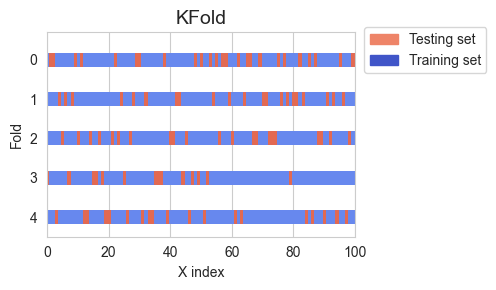

In [309]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [310]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', lightgbm_regressor)
]

In [311]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)

In [312]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


In [313]:
cv_results

{'fit_time': array([3.22328687, 3.22051072, 3.3069458 , 3.20680451, 3.20246816]),
 'score_time': array([0.02566767, 0.02212548, 0.01984715, 0.02282405, 0.0238862 ]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('drop_id', 'drop',
                                                    ['User_ID']),
                                                   ('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(fill_value='Missing',
                                 

In [314]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='LightGBM Regressor',
    modifiers='BP'
)

LightGBM Regressor (BP) - Fold 1:
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 860, number of used features: 45
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (0.01 MB) transferred to GPU in 0.001105 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 42.826744
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leave

In [315]:
all_metrics

[{'Model_Name': 'LightGBM Regressor (BP) | Fold 1',
  'Model_Metrics': {'MAE': 8.826291186039139,
   'MSE': 124.21587915046351,
   'RMSE': 11.145217770436947,
   'R-squared': 0.44126716930269116,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'LightGBM Regressor (BP) | Fold 2',
  'Model_Metrics': {'MAE': 7.8659800367056025,
   'MSE': 99.47050239767515,
   'RMSE': 9.973489980827932,
   'R-squared': 0.5453858412915904,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'LightGBM Regressor (BP) | Fold 3',
  'Model_Metrics': {'MAE': 6.594485580447342,
   'MSE': 74.57061545036656,
   'RMSE': 8.635427925144565,
   'R-squared': 0.6608841284186349,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'LightGBM Regressor (BP) | Fold 4',
  'Model_Metrics': {'MAE': 8.08663733989

In [316]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'LightGBM Regressor (BP) - CV',
 'Model_Metrics': {'MAE': np.float64(7.729335949669549),
  'MSE': np.float64(97.00037711173313),
  'RMSE': np.float64(9.812526550798387),
  'R-squared': np.float64(0.5544936788063195),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [317]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


np.float64(9.81506496844332)

In [318]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [319]:
model_performance_df.xs('LightGBM Regressor (BP) - CV')

,Score
Metric,
MAE,7.729336
MSE,97.000377
RMSE,9.812527
R-squared,0.554494
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, RMSE and MAE are lower than Standard Deviation, which means that the model predicted values tighter than natural variability of the true data itself. Besides that, MSE is lower than Variance, which is expectable, since RMSE, that is square root of MSE, is lower than Standard Deviation, which is the square root of Variance. Alongside with that, $R^2$ Score is $\approx 0.54$, which means that this model explains $54\%$ of the spread in age.

In [320]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [321]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,32.216875
544,54,48.263046
371,69,52.670312
552,28,34.096888
1331,38,37.997040
...,...,...
1096,61,56.776240
1131,62,59.588617
1295,46,40.081144


### eXtreme Gradient Boosting (XGBoost)

In [322]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2, 
                                 objective='reg:squarederror', 
                                 eval_metric='rmse')

In [323]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

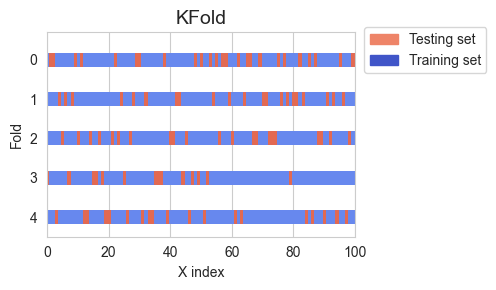

In [324]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [325]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', xgboost_regressor)
]

In [326]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)

In [327]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


In [328]:
cv_results

{'fit_time': array([1.9541626 , 2.00313759, 2.06247187, 1.99573588, 2.04687977]),
 'score_time': array([0.03664494, 0.02975059, 0.03165054, 0.03743815, 0.02352118]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('drop_id', 'drop',
                                                    ['User_ID']),
                                                   ('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(fill_value='Missing',
                                 

In [329]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='XGBoost Regressor',
    modifiers='BP'
)

XGBoost Regressor (BP) - Fold 1:
[14:50:58] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (860, 45, 38700).
[14:50:58] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
XGBoost Regressor (BP) - Fold 2:
[14:50:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (861, 45, 38745).
[14:50:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
XGBoost Regressor (BP) - Fold 3:
[14:50:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (861, 45, 38745).
[14:50:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
XGBoost Regressor (BP) - Fold 4:
[14:50:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:5

In [330]:
all_metrics

[{'Model_Name': 'XGBoost Regressor (BP) | Fold 1',
  'Model_Metrics': {'MAE': 6.767847061157227,
   'MSE': 84.95516967773438,
   'RMSE': 9.21711254119873,
   'R-squared': 0.6178649663925171,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'XGBoost Regressor (BP) | Fold 2',
  'Model_Metrics': {'MAE': 5.15540075302124,
   'MSE': 47.53153991699219,
   'RMSE': 6.894311904907227,
   'R-squared': 0.7827646136283875,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'XGBoost Regressor (BP) | Fold 3',
  'Model_Metrics': {'MAE': 4.071953296661377,
   'MSE': 30.749954223632812,
   'RMSE': 5.54526424407959,
   'R-squared': 0.8601621389389038,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'XGBoost Regressor (BP) | Fold 4',
  'Model_Metrics': {'MAE': 4.072185516357422,
   '

In [331]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'XGBoost Regressor (BP) - CV',
 'Model_Metrics': {'MAE': np.float64(4.94522705078125),
  'MSE': np.float64(46.45919532775879),
  'RMSE': np.float64(6.677202987670898),
  'R-squared': np.float64(0.7872781991958618),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [332]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


np.float64(6.677202987670898)

In [333]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [334]:
model_performance_df.xs('XGBoost Regressor (BP) - CV')

,Score
Metric,
MAE,4.945227
MSE,46.459195
RMSE,6.677203
R-squared,0.787278
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, RMSE and MAE are much lower than Standard Deviation, which means that the model predicted values tighter than natural variability of the true data itself. Besides that, MSE is lower than Variance, which is expectable, since RMSE, that is square root of MSE, is lower than Standard Deviation, which is the square root of Variance. Alongside with that, $R^2$ Score is $\approx 0.78$, which means that this model explains $78\%$ of the variability of age using features of the dataset.

In [335]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [336]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,35.168945
544,54,46.521500
371,69,56.387218
552,28,30.006725
1331,38,37.857460
...,...,...
1096,61,56.025379
1131,62,65.993462
1295,46,49.804485


## Random Forest Regressor

In [337]:
random_forest_regressor = RandomForestRegressor(n_jobs=-1, 
                                                random_state=42, 
                                                verbose=2)

In [338]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

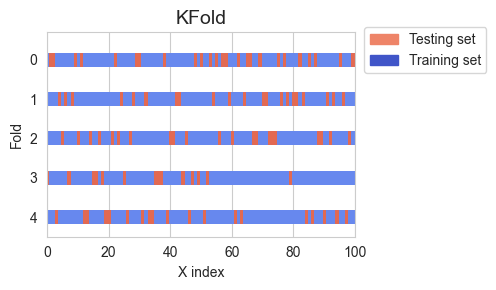

In [339]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [340]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', random_forest_regressor)
]

In [341]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)

In [342]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [343]:
cv_results

{'fit_time': array([0.23190928, 0.23585272, 0.22065115, 0.22353649, 0.22233295]),
 'score_time': array([0.04320669, 0.03319359, 0.03187442, 0.03125191, 0.03082943]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('drop_id', 'drop',
                                                    ['User_ID']),
                                                   ('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(fill_value='Missing',
                                 

In [344]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='Random Forest Regressor',
    modifiers='BP'
)

Random Forest Regressor (BP) - Fold 1:
building tree 1 of 100
building tree 4 of 100
building tree 9 of 100
building tree 8 of 100
building tree 13 of 100
building tree 2 of 100
building tree 6 of 100
building tree 7 of 100
building tree 15 of 100
building tree 5 of 100
building tree 10 of 100
building tree 11 of 100
building tree 14 of 100
building tree 16 of 100
building tree 12 of 100
building tree 17 of 100
building tree 3 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building t

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


building tree 55 of 100building tree 56 of 100
building tree 57 of 100

building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest Regressor (BP) - Fold 4:
building tree 1 of 100
building tree 6 of 100
building tree 9 of 100
building tree 11 of 100
building tree 2 of 100
building tree 8 of 100
building tree 14 of 100
building tree 3 of 100
building tree 10 of 100
building tree 13 of 100
building tree 12 of 100
building tree 15 of 100
building tree 4 of 100
building tree 16 of 100
building tree 5 of 100
building tree 7 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building t

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


building tree 45 of 100building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100

building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [345]:
all_metrics

[{'Model_Name': 'Random Forest Regressor (BP) | Fold 1',
  'Model_Metrics': {'MAE': 6.320740740740741,
   'MSE': 65.35412037037038,
   'RMSE': 8.08418953082932,
   'R-squared': 0.7060320071636073,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'Random Forest Regressor (BP) | Fold 2',
  'Model_Metrics': {'MAE': 5.222837209302325,
   'MSE': 46.30555023255814,
   'RMSE': 6.8048181630781395,
   'R-squared': 0.7883678250830225,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'Random Forest Regressor (BP) | Fold 3',
  'Model_Metrics': {'MAE': 5.657767441860465,
   'MSE': 51.95161209302326,
   'RMSE': 7.207746672367395,
   'R-squared': 0.7637458654648134,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'Random Forest Regressor (BP) | Fold 4',
  'Model_Metrics': {'MAE

In [346]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'Random Forest Regressor (BP) - CV',
 'Model_Metrics': {'MAE': np.float64(5.508864427217915),
  'MSE': np.float64(50.55288835314384),
  'RMSE': np.float64(7.089037834305702),
  'R-squared': np.float64(0.7680454825764575),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [347]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


np.float64(7.089037834305702)

In [348]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [349]:
model_performance_df.xs('Random Forest Regressor (BP) - CV')

,Score
Metric,
MAE,5.508864
MSE,50.552888
RMSE,7.089038
R-squared,0.768045
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, close results to XGBoost Regressor were obtained, RMSE and MAE are much lower than Standard Deviation, which means that the model predicted values tighter than natural variability of the true data itself. Besides that, MSE is lower than Variance, which is expectable, since RMSE, that is square root of MSE, is lower than Standard Deviation, which is the square root of Variance. Alongside with that, $R^2$ Score is $\approx 0.73$, which means that this model explains $73\%$ of the variability of age using features of the dataset.

In [350]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [351]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,34.73
544,54,48.81
371,69,52.93
552,28,31.07
1331,38,41.42
...,...,...
1096,61,57.40
1131,62,59.91
1295,46,44.97


## Linear Regression

In [352]:
linear_regressor = LinearRegression(n_jobs=-1)

In [353]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

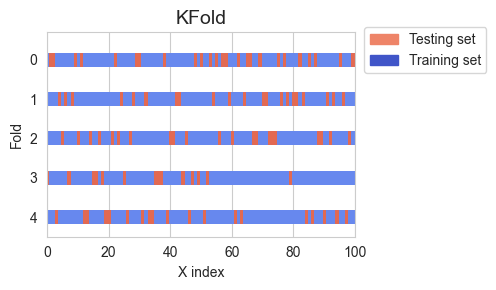

In [354]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [355]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', linear_regressor)
]

In [356]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)

In [357]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [358]:
cv_results

{'fit_time': array([0.01803827, 0.01716208, 0.02120066, 0.01728654, 0.01899529]),
 'score_time': array([0.01240492, 0.01501346, 0.01295519, 0.01035523, 0.00967979]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('drop_id', 'drop',
                                                    ['User_ID']),
                                                   ('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(fill_value='Missing',
                                 

In [359]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='Linear Regressor',
    modifiers='BP'
)

Linear Regressor (BP) - Fold 1:
Linear Regressor (BP) - Fold 2:
Linear Regressor (BP) - Fold 3:
Linear Regressor (BP) - Fold 4:
Linear Regressor (BP) - Fold 5:


In [360]:
all_metrics

[{'Model_Name': 'Linear Regressor (BP) | Fold 1',
  'Model_Metrics': {'MAE': 12.541941526949048,
   'MSE': 210.76315923183378,
   'RMSE': 14.517684361902685,
   'R-squared': 0.051970670982682377,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'Linear Regressor (BP) | Fold 2',
  'Model_Metrics': {'MAE': 12.073898389978241,
   'MSE': 201.5140302717217,
   'RMSE': 14.195563753219584,
   'R-squared': 0.07901207763417417,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'Linear Regressor (BP) | Fold 3',
  'Model_Metrics': {'MAE': 12.14390250219528,
   'MSE': 202.4820502466293,
   'RMSE': 14.229618766735436,
   'R-squared': 0.07919659058372541,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'Linear Regressor (BP) | Fold 4',
  'Model_Metrics': {'MAE': 12.055637471084

In [361]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'Linear Regressor (BP) - CV',
 'Model_Metrics': {'MAE': np.float64(12.163220678651681),
  'MSE': np.float64(204.18494427048404),
  'RMSE': np.float64(14.28879304564941),
  'R-squared': np.float64(0.06104972198655316),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [362]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


np.float64(14.28879304564941)

In [363]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [364]:
model_performance_df.xs('Linear Regressor (BP) - CV')

,Score
Metric,
MAE,12.163221
MSE,204.184944
RMSE,14.288793
R-squared,0.061050
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, this model performed the worst, due to the minimal modifications of the original dataset. However, RMSE and MAE are slightly lower than Standard Deviation, which means that the model predicted values close to natural variability of the true data. Besides that, MSE is slightly lower than Variance. Alongside with that, $R^2$ Score is $\approx 0.06$, which means that this model explains only $6\%$ of the variability of age using features of the dataset.

In [365]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [366]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,40.459025
544,54,44.555007
371,69,48.440952
552,28,45.062849
1331,38,45.877312
...,...,...
1096,61,41.626341
1131,62,52.669325
1295,46,44.233747


### Baseline Performance - Summary
Advanced algorithms, like XGBoost and Random Forest Regressors, performed well on the baseline dataset, with better predictions than if model predicted everytime mean value of $y$ target variable, or mean age. Linear Regression performed worse. Underlying causes may be unscaled dataset, or non-linear relationships between each feature and target variable. Overall, best performing model was XGBoost and Random Forest Regressors, with $R^2$ Score above $0.7$ and low MSE and MAE - $\approx 50-60$ and $\approx 5$, meaning that prediction on average were off by $5$ units in prediction, and, by division to Standard Deviation, was concluded that prediction error on average is $\approx 33\%$ of the typical spread of the age in the dataset.

In [367]:
model_performance_df.loc[model_names_cv]

Score
Model                             Metric                       
LightGBM Regressor (BP) - CV      MAE                  7.729336
                                  MSE                 97.000377
                                  RMSE                 9.812527
                                  R-squared            0.554494
                                  Variance (y_true)  217.492653
                                  Std (y_true)        14.747008
Linear Regressor (BP) - CV        MAE                 12.163221
                                  MSE                204.184944
                                  RMSE                14.288793
                                  R-squared            0.061050
                                  Variance (y_true)  217.492653
                                  Std (y_true)        14.747008
Random Forest Regressor (BP) - CV MAE                  5.508864
                                  MSE                 50.552888
                                  RMSE                 7.089038
                                  R-squared            0.768045
                                  Variance (y_true)  217.492653
                                  Std (y_true)        14.747008
XGBoost Regressor (BP) - CV       MAE                  4.945227
                                  MSE                 46.459195
                                  RMSE                 6.677203
                                  R-squared            0.787278
                                  Variance (y_true)  217.492653
                                  Std (y_true)        14.747008

{'LightGBM Regressor (BP) - CV': 'red', 'Linear Regressor (BP) - CV': 'orange', 'Random Forest Regressor (BP) - CV': 'yellow', 'XGBoost Regressor (BP) - CV': 'blue'}


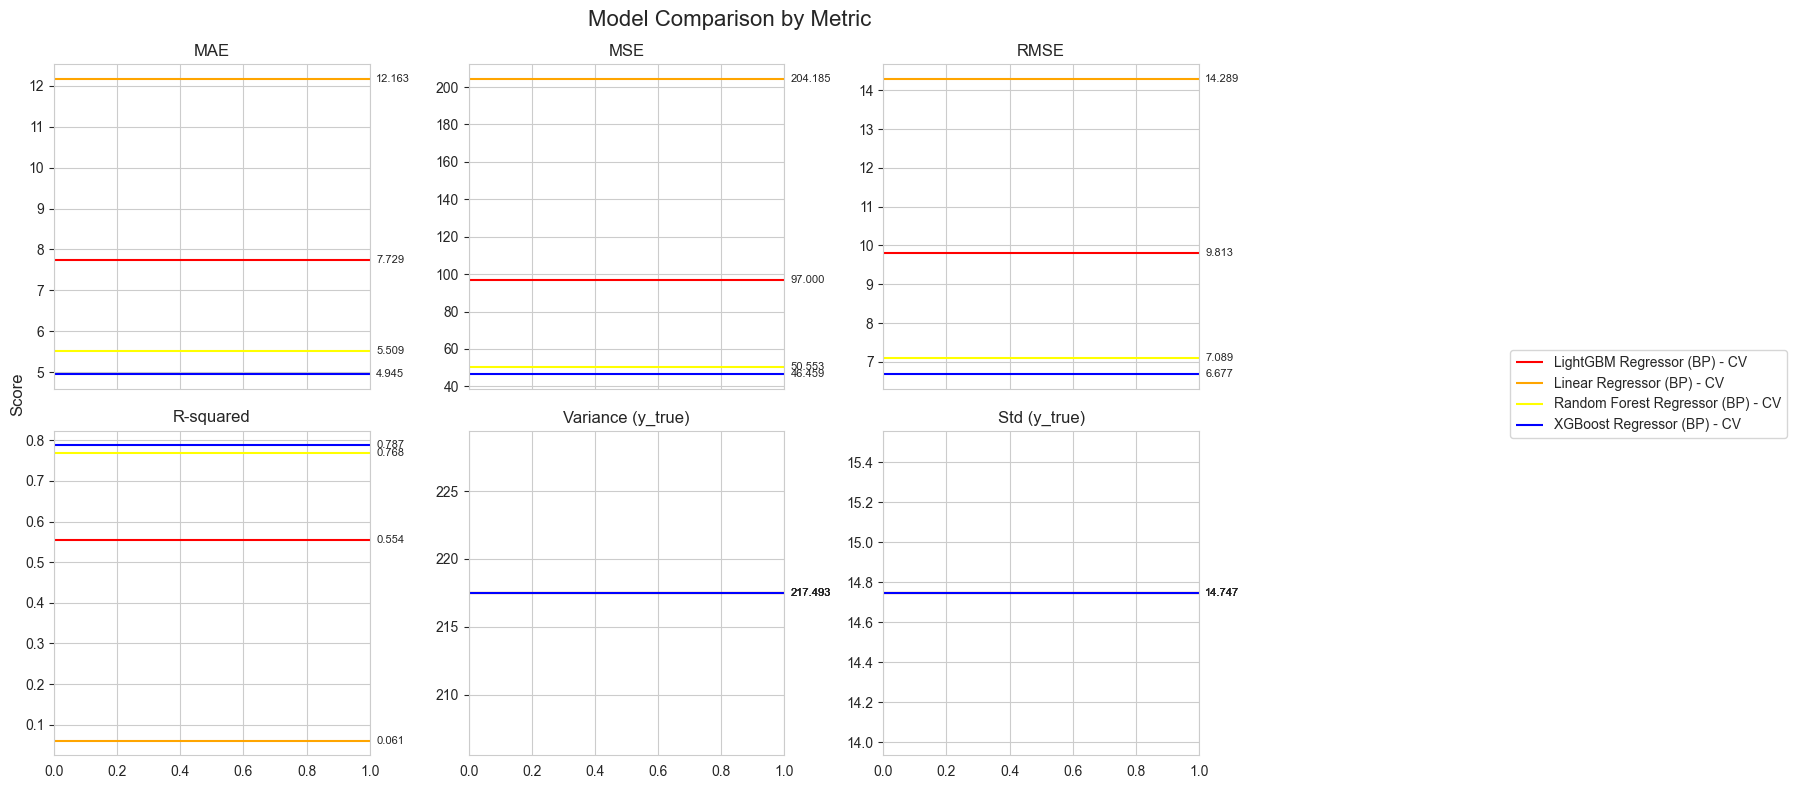

In [368]:
plot_metrics(metrics_df=model_performance_df.loc[model_names_cv])

## Missing Values Imputation

### Mode Imputation

### Utils - Mode Imputation

In [369]:
model_names_cv: list[str] = ['LightGBM Regressor (MVImp - Mode) - CV', 'Linear Regressor (MVImp - Mode) - CV', 'Random Forest Regressor (MVImp - Mode) - CV', 'XGBoost Regressor (MVImp - Mode) - CV']

### Basic Transformations
Besides basic transformations, from baseline performance - OneHotEncoding, was implemented Missing Values Imputation with Mode (Most Frequent Value) imputation, while in baseline performance missing values in Event Impact Feature was replaced with a new category - "Missing".

In [370]:
simple_imputer_const: SimpleImputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')

In [371]:
one_hot_encoder: OneHotEncoder = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')

In [372]:
encoder_transformer: ColumnTransformer = ColumnTransformer(
    transformers=[
        ('one_hot_encode_categorical', one_hot_encoder, pd.Index(categorical_features).difference(other=['User_ID', 'Sequence', 'Optimal_Route_Preference']))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [373]:
imputer_transformer: ColumnTransformer = ColumnTransformer(
    transformers=[
        ('impute_event_impact', simple_imputer_const, ['Event_Impact'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [374]:
imp_enc_pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('imputer_step', imputer_transformer),
    ('one_hot_encoder_step', encoder_transformer)
]

In [375]:
imp_enc_pipeline: Pipeline = create_pipeline(steps=imp_enc_pipeline_steps)

In [376]:
# def compute_num_stops(X):
#     X_copy = X.copy()
#     X_copy['Num_Stops'] = X_copy['Sequence'].str.split('->').str.len()
#     return X_copy

# def inv_compute_num_stops(X):
#     X_copy = X.copy()
#     X_copy.drop(columns=['Num_Stops'], inplace=True)
#     return X_copy

In [377]:
# def compute_num_optimal_stops(X):
#     X_copy = X.copy()
#     X_copy['Num_Optimal_Stops'] = X_copy.apply(
#         lambda row: np.sum(
#             np.array(row['Sequence'].split('->')) == np.array(row['Optimal_Route_Preference'].split('->'))
#         ),
#         axis=1
#     )
#     return X_copy

# def inv_compute_num_optimal_stops(X):
#     X_copy = X.copy()
#     X_copy.drop(columns=['Num_Optimal_Stops'], inplace=True)
#     return X_copy

In [378]:
# num_stops_transformer = FunctionTransformer(func=compute_num_stops,
#                                                 validate=False).set_output(transform='pandas')

In [379]:
# num_optimal_stops_transformer = FunctionTransformer(func=compute_num_optimal_stops,
#                                                 validate=False).set_output(transform='pandas')

In [380]:
# num_stops_col_transformer: ColumnTransformer = ColumnTransformer(
#     transformers=[
#         ('compute_num_stops', num_stops_transformer, ['Sequence'])
#     ],
#     remainder='passthrough',
#     verbose_feature_names_out=False
# ).set_output(transform='pandas')

In [381]:
# num_opt_stops_col_transformer: ColumnTransformer = ColumnTransformer(
#     transformers=[
#         ('compute_num_opt_stops', num_optimal_stops_transformer, ['Sequence', 'Optimal_Route_Preference'])
#     ],
#     remainder='passthrough',
#     verbose_feature_names_out=False
# ).set_output(transform='pandas')

In [382]:
# num_stops_pipeline_steps: list[tuple[str, TransformerMixin]] = [
#     # ('compute_num_stops', num_stops_col_transformer),
#     ('compute_num_stops', num_stops_transformer),
#     # ('compute_optimal_num_stops', num_opt_stops_col_transformer),
# ]

In [383]:
# num_stops_pipeline = create_pipeline(steps=num_stops_pipeline_steps)

In [384]:
preprocessing_transformer = ColumnTransformer(
    transformers=[
        # ('drop_id', 'drop', ['User_ID']),
        # ('compute_num_stops', num_stops_transformer, ['Sequence', 'Optimal_Route_Preference']),
        ('impute_encode_categorical', imp_enc_pipeline, pd.Index(categorical_features).difference(other=['Sequence', 'Optimal_Route_Preference']))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [385]:
final_dropper_transformer = ColumnTransformer(
    transformers=[
        ('drop_sequences', 'drop', ['User_ID', 'Sequence', 'Optimal_Route_Preference'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [386]:
dataset_preprocessing_pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer)
]

In [387]:
dataset_preprocessing_pipeline: Pipeline = create_pipeline(
    steps=dataset_preprocessing_pipeline_steps
)
dataset_preprocessing_pipeline

,steps,"[('preprocessing_transformer', ...), ('final_dropper_transformer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('impute_encode_categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### Light Gradient Boost Model (LightGBM)

In [388]:
lightgbm_regressor = LGBMRegressor(n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2, 
                                   objective='regression', 
                                   metric='rmse')

In [389]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

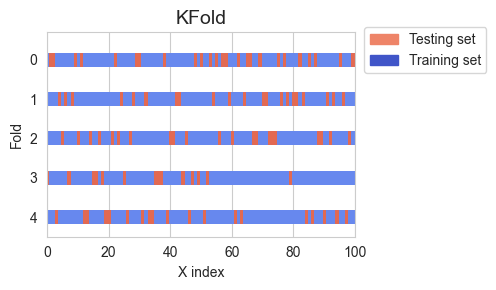

In [390]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [391]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', lightgbm_regressor)
]

In [392]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)
pipeline

,steps,"[('preprocessing_transformer', ...), ('final_dropper_transformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('impute_encode_categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [393]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


In [394]:
cv_results

{'fit_time': array([0.99665618, 2.41969895, 2.45501828, 2.44016695, 2.44061828]),
 'score_time': array([0.01432681, 0.0165441 , 0.01610923, 0.01801848, 0.01923585]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(strategy='most_frequent'),
                                                                                                      ['Event_Impact'])],
                                           

In [395]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='LightGBM Regressor',
    modifiers='MVImp - Mode'
)

LightGBM Regressor (MVImp - Mode) - Fold 1:
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.679070
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 860, number of used features: 43
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (0.01 MB) transferred to GPU in 0.001120 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 42.826744
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] T

In [396]:
all_metrics

[{'Model_Name': 'LightGBM Regressor (MVImp - Mode) | Fold 1',
  'Model_Metrics': {'MAE': 8.559550446456415,
   'MSE': 121.26737758901139,
   'RMSE': 11.012146820171415,
   'R-squared': 0.45452976209688656,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'LightGBM Regressor (MVImp - Mode) | Fold 2',
  'Model_Metrics': {'MAE': 7.736769795381971,
   'MSE': 93.34758972754972,
   'RMSE': 9.661655641118127,
   'R-squared': 0.5733696427732164,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'LightGBM Regressor (MVImp - Mode) | Fold 3',
  'Model_Metrics': {'MAE': 6.495597841278623,
   'MSE': 73.01502697719285,
   'RMSE': 8.544883087391709,
   'R-squared': 0.6679582921185891,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'LightGBM Regressor (MVImp - Mode) | Fold 4',
 

In [397]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'LightGBM Regressor (MVImp - Mode) - CV',
 'Model_Metrics': {'MAE': np.float64(7.60113352416928),
  'MSE': np.float64(94.91595075563953),
  'RMSE': np.float64(9.710551162906125),
  'R-squared': np.float64(0.5638566393002252),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [398]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


np.float64(9.709057743164475)

In [399]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [400]:
model_performance_df.xs('LightGBM Regressor (MVImp - Mode) - CV')

,Score
Metric,
MAE,7.601134
MSE,94.915951
RMSE,9.710551
R-squared,0.563857
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, RMSE and MAE are lower than Standard Deviation, which means that the model predicted values tighter than natural variability of the true data itself. Besides that, MSE is lower than Variance, which is expectable, since RMSE, that is square root of MSE, is lower than Standard Deviation, which is the square root of Variance. Alongside with that, $R^2$ Score is $\approx 0.54$, which means that this model explains $54\%$ of the spread in age.

In [401]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [402]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,31.983945
544,54,46.676857
371,69,51.628384
552,28,32.250196
1331,38,39.392282
...,...,...
1096,61,53.547901
1131,62,61.648849
1295,46,43.219138


### eXtreme Gradient Boosting (XGBoost)

In [403]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2, 
                                 objective='reg:squarederror', 
                                 eval_metric='rmse')

In [404]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

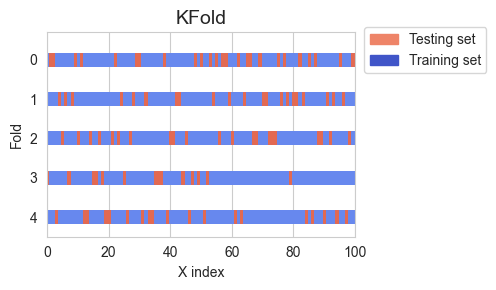

In [405]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [406]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', xgboost_regressor)
]

In [407]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)

In [408]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [409]:
cv_results

{'fit_time': array([0.91010284, 1.6327455 , 1.40836143, 1.63371325, 1.62899947]),
 'score_time': array([0.02943683, 0.02804112, 0.0251627 , 0.02673554, 0.03083658]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(strategy='most_frequent'),
                                                                                                      ['Event_Impact'])],
                                           

In [410]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='XGBoost Regressor',
    modifiers='MVImp - Mode'
)

XGBoost Regressor (MVImp - Mode) - Fold 1:
[14:51:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (860, 43, 36980).
[14:51:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
XGBoost Regressor (MVImp - Mode) - Fold 2:
[14:51:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (861, 43, 37023).
[14:51:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
XGBoost Regressor (MVImp - Mode) - Fold 3:
[14:51:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (861, 43, 37023).
[14:51:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
XGBoost Regressor (MVImp - Mode) - Fold 4:
[14:51:20] INFO: C:\actions-runner\_work\xgboost

In [411]:
all_metrics

[{'Model_Name': 'XGBoost Regressor (MVImp - Mode) | Fold 1',
  'Model_Metrics': {'MAE': 6.537914276123047,
   'MSE': 77.22716522216797,
   'RMSE': 8.787899017333984,
   'R-squared': 0.652626097202301,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'XGBoost Regressor (MVImp - Mode) | Fold 2',
  'Model_Metrics': {'MAE': 5.621059894561768,
   'MSE': 54.17298889160156,
   'RMSE': 7.360230445861816,
   'R-squared': 0.7524109482765198,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'XGBoost Regressor (MVImp - Mode) | Fold 3',
  'Model_Metrics': {'MAE': 4.348487854003906,
   'MSE': 34.86296463012695,
   'RMSE': 5.904486656188965,
   'R-squared': 0.8414578437805176,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'XGBoost Regressor (MVImp - Mode) | Fold 4',
  'Model_

In [412]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'XGBoost Regressor (MVImp - Mode) - CV',
 'Model_Metrics': {'MAE': np.float64(5.043368005752564),
  'MSE': np.float64(46.75122146606445),
  'RMSE': np.float64(6.727238273620605),
  'R-squared': np.float64(0.7860972881317139),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [413]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


np.float64(6.727238273620605)

In [414]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [415]:
model_performance_df.xs('XGBoost Regressor (MVImp - Mode) - CV')

,Score
Metric,
MAE,5.043368
MSE,46.751221
RMSE,6.727238
R-squared,0.786097
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, RMSE and MAE are much lower than Standard Deviation, which means that the model predicted values tighter than natural variability of the true data itself. Besides that, MSE is lower than Variance, which is expectable, since RMSE, that is square root of MSE, is lower than Standard Deviation, which is the square root of Variance. Alongside with that, $R^2$ Score is $\approx 0.78$, which means that this model explains $78\%$ of the variability of age using features of the dataset.

In [416]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [417]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,35.353195
544,54,49.312061
371,69,48.610603
552,28,32.565445
1331,38,44.970383
...,...,...
1096,61,58.764214
1131,62,59.391338
1295,46,43.917175


## Random Forest Regressor

In [418]:
random_forest_regressor = RandomForestRegressor(n_jobs=-1, 
                                                random_state=42, 
                                                verbose=2)

In [419]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

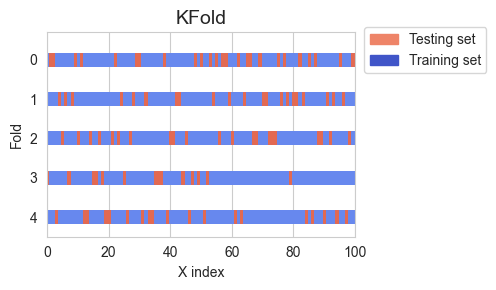

In [420]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [421]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', random_forest_regressor)
]

In [422]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)

In [423]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [424]:
cv_results

{'fit_time': array([0.18416381, 0.20103383, 0.18060422, 0.24166751, 0.19183564]),
 'score_time': array([0.06198859, 0.04738736, 0.06295824, 0.03455687, 0.04675913]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(strategy='most_frequent'),
                                                                                                      ['Event_Impact'])],
                                           

In [425]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='Random Forest Regressor',
    modifiers='MVImp - Mode'
)

Random Forest Regressor (MVImp - Mode) - Fold 1:
building tree 1 of 100
building tree 5 of 100
building tree 2 of 100
building tree 11 of 100
building tree 13 of 100
building tree 16 of 100
building tree 4 of 100
building tree 9 of 100
building tree 12 of 100
building tree 15 of 100
building tree 6 of 100
building tree 8 of 100
building tree 14 of 100
building tree 10 of 100
building tree 3 of 100
building tree 7 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


building tree 2 of 100
building tree 4 of 100
building tree 14 of 100
building tree 7 of 100
building tree 8 of 100
building tree 5 of 100
building tree 12 of 100
building tree 13 of 100
building tree 17 of 100
building tree 11 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 1

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest Regressor (MVImp - Mode) - Fold 4:
building tree 1 of 100
building tree 6 of 100
building tree 9 of 100
building tree 4 of 100
building tree 13 of 100
building tree 16 of 100
building tree 8 of 100
building tree 12 of 100
building tree 14 of 100
building tree 2 of 100
building tree 7 of 100
building tree 11 of 100
building tree 5 of 100
building tree 10 of 100
building tree 3 of 100
building tree 15 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 74 of 100
building tree 79 of 100
building tree 82 of 100
building tree 85 of 100
building tree 80 of 100
building tree 83 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 78 of 100
building tree 90 of 100
building tree 91 of 100
building tree 84 of 100
building tree 92 of 100
building tree 93 of 100
building tree 81 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [426]:
all_metrics

[{'Model_Name': 'Random Forest Regressor (MVImp - Mode) | Fold 1',
  'Model_Metrics': {'MAE': 6.239814814814815,
   'MSE': 63.91227962962963,
   'RMSE': 7.994515596934541,
   'R-squared': 0.7125175206422257,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'Random Forest Regressor (MVImp - Mode) | Fold 2',
  'Model_Metrics': {'MAE': 5.153674418604651,
   'MSE': 45.275414883720934,
   'RMSE': 6.72870083178922,
   'R-squared': 0.7930758953518862,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'Random Forest Regressor (MVImp - Mode) | Fold 3',
  'Model_Metrics': {'MAE': 5.598558139534883,
   'MSE': 50.14632697674418,
   'RMSE': 7.081407132536879,
   'R-squared': 0.771955544732746,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'Random Forest Regressor (MVImp - Mo

In [427]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'Random Forest Regressor (MVImp - Mode) - CV',
 'Model_Metrics': {'MAE': np.float64(5.377683893195521),
  'MSE': np.float64(48.318473321274766),
  'RMSE': np.float64(6.925817189355984),
  'R-squared': np.float64(0.7783737317875419),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [428]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


np.float64(6.925817189355984)

In [429]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [430]:
model_performance_df.xs('Random Forest Regressor (MVImp - Mode) - CV')

,Score
Metric,
MAE,5.377684
MSE,48.318473
RMSE,6.925817
R-squared,0.778374
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, close results to XGBoost Regressor were obtained, RMSE and MAE are much lower than Standard Deviation, which means that the model predicted values tighter than natural variability of the true data itself. Besides that, MSE is lower than Variance, which is expectable, since RMSE, that is square root of MSE, is lower than Standard Deviation, which is the square root of Variance. Alongside with that, $R^2$ Score is $\approx 0.73$, which means that this model explains $73\%$ of the variability of age using features of the dataset.

In [431]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [432]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,35.83
544,54,47.24
371,69,51.54
552,28,30.92
1331,38,41.63
...,...,...
1096,61,58.37
1131,62,60.23
1295,46,44.27


## Linear Regression

In [433]:
linear_regressor = LinearRegression(n_jobs=-1)

In [434]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

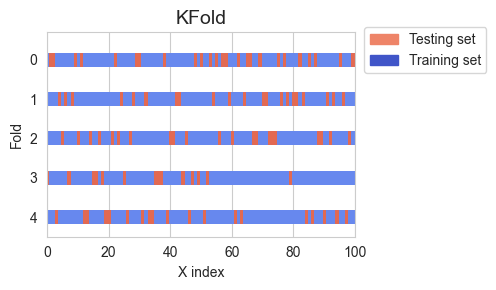

In [435]:
plot_kfold(cv=k_fold, X=X_train, y=y_train, n_splits=5)

In [436]:
pipeline_steps: list[tuple[str, TransformerMixin]] = [
    ('preprocessing_transformer', preprocessing_transformer),
    ('final_dropper_transformer', final_dropper_transformer),
    ('model', linear_regressor)
]

In [437]:
pipeline: Pipeline = create_pipeline(
    steps=pipeline_steps
)

In [438]:
cv_results = cross_validate(estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=k_fold,
                    return_estimator=True,
                    return_indices=True,
                    scoring=scoring_dict,
                    n_jobs=-1,
                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [439]:
cv_results

{'fit_time': array([0.01847053, 0.02207065, 0.01803803, 0.01895881, 0.01799035]),
 'score_time': array([0.0112586 , 0.01089811, 0.01036525, 0.0100174 , 0.00999165]),
 'estimator': [Pipeline(steps=[('preprocessing_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('impute_encode_categorical',
                                                    Pipeline(steps=[('imputer_step',
                                                                     ColumnTransformer(remainder='passthrough',
                                                                                       transformers=[('impute_event_impact',
                                                                                                      SimpleImputer(strategy='most_frequent'),
                                                                                                      ['Event_Impact'])],
                                           

In [440]:
all_y_true, all_y_pred, all_metrics = calculate_preds_metrics(
    X_train_cv=X_train,
    y_train_cv=y_train,
    cv_alg=k_fold,
    estimator=pipeline,
    estimator_name='Linear Regressor',
    modifiers='MVImp - Mode'
)

Linear Regressor (MVImp - Mode) - Fold 1:
Linear Regressor (MVImp - Mode) - Fold 2:
Linear Regressor (MVImp - Mode) - Fold 3:
Linear Regressor (MVImp - Mode) - Fold 4:
Linear Regressor (MVImp - Mode) - Fold 5:


In [441]:
all_metrics

[{'Model_Name': 'Linear Regressor (MVImp - Mode) | Fold 1',
  'Model_Metrics': {'MAE': 12.540740811095063,
   'MSE': 210.69005719565234,
   'RMSE': 14.515166454286783,
   'R-squared': 0.05229948971249965,
   'Variance (y_true)': np.float64(222.31712962962962),
   'Std (y_true)': np.float64(14.91030280140647)}},
 {'Model_Name': 'Linear Regressor (MVImp - Mode) | Fold 2',
  'Model_Metrics': {'MAE': 12.069456812811099,
   'MSE': 201.48621289981816,
   'RMSE': 14.194583928379801,
   'R-squared': 0.07913921252160894,
   'Variance (y_true)': np.float64(218.80203353163873),
   'Std (y_true)': np.float64(14.791958407582099)}},
 {'Model_Name': 'Linear Regressor (MVImp - Mode) | Fold 3',
  'Model_Metrics': {'MAE': 12.142893165925361,
   'MSE': 202.32465475647356,
   'RMSE': 14.224087132623787,
   'R-squared': 0.07991235923475215,
   'Variance (y_true)': np.float64(219.89715521903733),
   'Std (y_true)': np.float64(14.82892967206458)}},
 {'Model_Name': 'Linear Regressor (MVImp - Mode) | Fold 4',


In [442]:
mean_metrics = calculate_mean_metrics_cv(all_metrics=all_metrics)
mean_metrics

{'Model_Name': 'Linear Regressor (MVImp - Mode) - CV',
 'Model_Metrics': {'MAE': np.float64(12.149728008182134),
  'MSE': np.float64(203.83834913133626),
  'RMSE': np.float64(14.276633916381883),
  'R-squared': np.float64(0.06266596721045026),
  'Variance (y_true)': np.float64(217.4926525349038),
  'Std (y_true)': np.float64(14.747007521309618)}}

In [443]:
-np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='neg_root_mean_squared_error', cv=k_fold, n_jobs=-1, verbose=2), axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


np.float64(14.276633916381883)

In [444]:
model_performance_df = add_to_df(metrics_dict=mean_metrics['Model_Metrics'], estimator_name=mean_metrics['Model_Name'], old_df=model_performance_df)

In [445]:
model_performance_df.xs('Linear Regressor (MVImp - Mode) - CV')

,Score
Metric,
MAE,12.149728
MSE,203.838349
RMSE,14.276634
R-squared,0.062666
Variance (y_true),217.492653
Std (y_true),14.747008


As it may be seen, this model performed the worst, due to the minimal modifications of the original dataset. However, RMSE and MAE are slightly lower than Standard Deviation, which means that the model predicted values close to natural variability of the true data. Besides that, MSE is slightly lower than Variance. Alongside with that, $R^2$ Score is $\approx 0.06$, which means that this model explains only $6\%$ of the variability of age using features of the dataset.

In [446]:
comparison_df = create_comparison_df(y_true=all_y_true, 
                                     y_pred=all_y_pred)

In [447]:
comparison_df

,y_true,y_pred
Route_ID,,
395,34,40.440369
544,54,44.959776
371,69,48.337029
552,28,45.140187
1331,38,46.241234
...,...,...
1096,61,41.928863
1131,62,52.774546
1295,46,44.400182


### Missing Values Imputation - Summary
Advanced algorithms, like XGBoost and Random Forest Regressors, performed well on the dataset with Mode Imputation, with better predictions than if model predicted everytime mean value of $y$ target variable, or mean age. Linear Regression performed worse. Underlying causes may be the same as in previous section. Overall, best performing model was XGBoost and Random Forest Regressors, with $R^2$ Score still above $0.7$, slightly lower than in Baseline Performance, and slightly higher MSE for both best performing models so far, and lower MAE for Random Forest - $\approx 48$, higher MAE for XGBoost and $\approx 5.1$, meaning that prediction on average were off by $5.1$ units in prediction, and, by division to Standard Deviation, was concluded that prediction error on average is $\approx 34\%$ of the typical spread of the age in the dataset.

In [448]:
model_performance_df.loc[model_names_cv]

Score
Model                                       Metric                       
LightGBM Regressor (MVImp - Mode) - CV      MAE                  7.601134
                                            MSE                 94.915951
                                            RMSE                 9.710551
                                            R-squared            0.563857
                                            Variance (y_true)  217.492653
                                            Std (y_true)        14.747008
Linear Regressor (MVImp - Mode) - CV        MAE                 12.149728
                                            MSE                203.838349
                                            RMSE                14.276634
                                            R-squared            0.062666
                                            Variance (y_true)  217.492653
                                            Std (y_true)        14.747008
Random Forest Regressor (MVImp - Mode) - CV MAE                  5.377684
                                            MSE                 48.318473
                                            RMSE                 6.925817
                                            R-squared            0.778374
                                            Variance (y_true)  217.492653
                                            Std (y_true)        14.747008
XGBoost Regressor (MVImp - Mode) - CV       MAE                  5.043368
                                            MSE                 46.751221
                                            RMSE                 6.727238
                                            R-squared            0.786097
                                            Variance (y_true)  217.492653
                                            Std (y_true)        14.747008

{'LightGBM Regressor (MVImp - Mode) - CV': 'red', 'Linear Regressor (MVImp - Mode) - CV': 'orange', 'Random Forest Regressor (MVImp - Mode) - CV': 'yellow', 'XGBoost Regressor (MVImp - Mode) - CV': 'blue'}


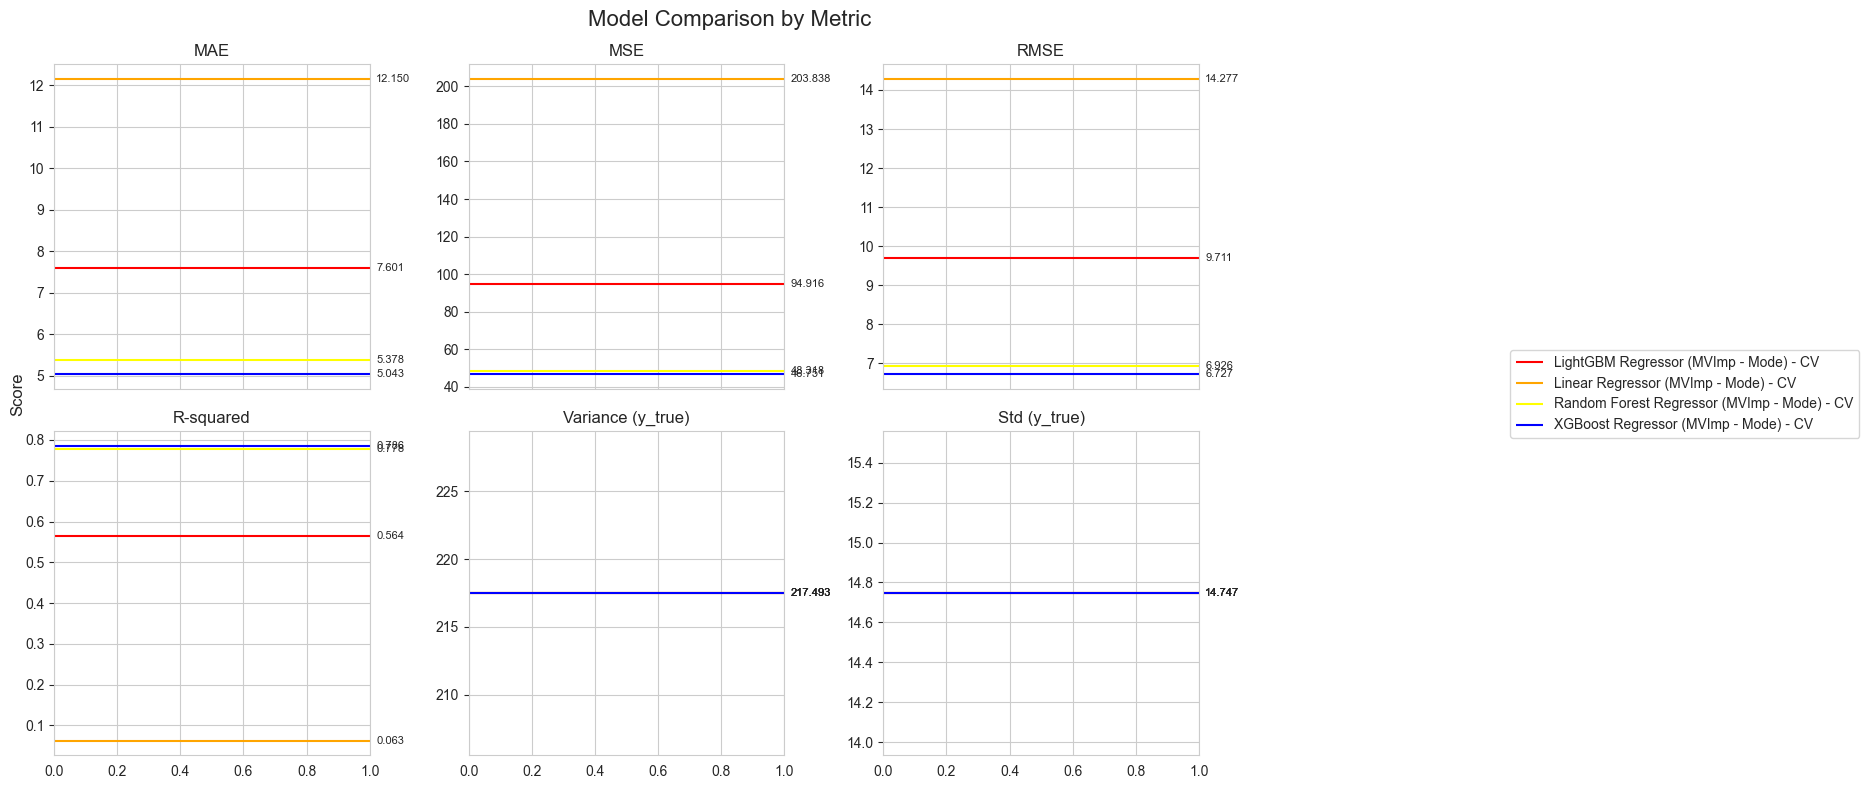

In [449]:
plot_metrics(metrics_df=model_performance_df.loc[model_names_cv])

In [450]:
# import matplotlib.pyplot as plt
# import numpy as np

# residuals = all_y_true - all_y_pred
# MAE = np.mean(np.abs(residuals))
# RMSE = np.sqrt(np.mean(residuals**2))
# std_y = np.std(all_y_true)

# fig, axes = plt.subplots(2, 2, figsize=(12,10))

# # 1. Predicted vs Actual
# axes[0,0].scatter(all_y_true, all_y_pred, color='blue', alpha=0.6)
# axes[0,0].plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--')
# axes[0,0].set_xlabel('Actual Values')
# axes[0,0].set_ylabel('Predicted Values')
# axes[0,0].set_title('Predicted vs Actual')

# # 2. Residuals plot
# axes[0,1].scatter(all_y_true, residuals, color='orange', alpha=0.6)
# axes[0,1].hlines(0, xmin=min(all_y_true), xmax=max(all_y_true), colors='r', linestyles='--')
# axes[0,1].set_xlabel('Actual Values')
# axes[0,1].set_ylabel('Residuals')
# axes[0,1].set_title('Residuals vs Actual')

# # 3. Histogram of residuals
# axes[1,0].hist(residuals, bins=20, color='green', alpha=0.7)
# axes[1,0].set_xlabel('Residual')
# axes[1,0].set_ylabel('Frequency')
# axes[1,0].set_title('Residuals Histogram')

# # 4. Errors vs Target Spread
# axes[1,1].bar(['MAE','RMSE','Std(y)'], [MAE, RMSE, std_y], color=['skyblue','orange','green'])
# axes[1,1].set_ylabel('Units')
# axes[1,1].set_title('Errors vs Target Spread')

# plt.tight_layout()
# plt.show()
